In [62]:
import xlrd
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as dt
import seaborn as sns

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm

!pip install pandas nltk textblob
from textblob import TextBlob

from wordcloud import WordCloud, STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import nltk

# 1. Data Cleaning and Pre-processing

## 1.1 Import Data

In [2]:
raw_transaction = pd.read_excel('Data Test - Analytics Lending.xlsx', sheet_name='actual_transaction')
product_detail = pd.read_excel('Data Test - Analytics Lending.xlsx', sheet_name='product_master')

In [3]:
raw_transaction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1465 entries, 0 to 1464
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   user_id              1465 non-null   object        
 1   user_name            1465 non-null   object        
 2   transaction_date     1465 non-null   datetime64[ns]
 3   product_id           1465 non-null   object        
 4   discounted_price     1465 non-null   object        
 5   actual_price         1465 non-null   object        
 6   discount_percentage  1465 non-null   float64       
 7   review_id            1465 non-null   object        
 8   review_title         1465 non-null   object        
 9   review_content       1465 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(8)
memory usage: 114.6+ KB


In [4]:
product_detail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1465 entries, 0 to 1464
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   product_id     1465 non-null   object
 1   product_name   1465 non-null   object
 2   category       1465 non-null   object
 3   rating         1465 non-null   object
 4   rating_count   1463 non-null   object
 5   about_product  1465 non-null   object
 6   img_link       1465 non-null   object
 7   product_link   1465 non-null   object
dtypes: object(8)
memory usage: 91.7+ KB


## 1.2 Clean the pricing and datetime format

In [5]:
raw_transaction['discounted_price'] = raw_transaction['discounted_price'].str.replace('₹', '').str.replace(',', '').astype(float)
raw_transaction['actual_price'] = raw_transaction['actual_price'].str.replace('₹', '').str.replace(',', '').astype(float)

In [6]:
raw_transaction['transaction_date'] = pd.to_datetime(raw_transaction['transaction_date'], format='%d-%m-%Y')

In [7]:
raw_transaction

,user_id,user_name,transaction_date,product_id,discounted_price,actual_price,discount_percentage,review_id,review_title,review_content
0,"AEAD2LHI2R3QVR3AQKOPB523SVUA,AGHZS375UQZ6XK6BY...","Aksa akhila,Subhadip,Kanna Keerthi,shopping Us...",2019-01-01,B00LHZWD0C,252.0,315.0,0.20,"R1ERT7AXR5RE2,R1OBNL676FOQDS,R3FYTFWQDO4FYY,R2...","Good note book,Five Star Product,Nothing,Not b...",Nice notebook with sufficiently good quality p...
1,"AGPGSHGMGBF6GBOQ7ZXUBQ3IFZJA,AGCTDYXDS2ERAZO6A...","Aditya Chatterjee,Raksha,shubham s.,Lucky mir,...",2019-01-01,B00P93X0VO,1140000.0,120.0,0.05,"RFFLKG1LJ0XOI,R8X3CAMJEQANF,R31072TMP1DQYQ,R1Y...","Great Build Quality!,Great condition,Nice,Good...","The covers are sturdy, flexible and compelling..."
2,"AHQC27SWWMUOTO3W7NGIG7KPX2AQ,AH3ZNJWSAOEWIBD3N...","MOINUL H.,Jayendra Pai,Avinash kumar,Sreekanth...",2019-01-01,B00V4BGDKU,1099.0,1899.0,0.42,"R30SWI8U6K7PDR,R2K3WL7JFGLDI,R2WXWZRPAKQ1GP,R2...","Easy to use,Working fine - but errors while us...","Good looking amd working fine.,I brought this ..."
3,"AH5ZFNLZLJW24YKDQMDHCWGT3MLA,AETSU7SDMZB4653PY...","Mohammad Noushad,Ramkumar.R,Sreeram,Gs7,Dongay...",2019-01-01,B01HJI0FS2,299.0,650.0,0.54,"R2K3IBMM9I3HQH,RL1H11C1J4W4U,R26GYIVCHR44IY,R2...",Big in size as comparison to other normal size...,I'm using this mouse from more than 6 months n...
4,"AG3D6O4STAQKAY2UVGEUV46KN35Q,AHMY5CWJMMK5BJRBB...","Manav,Adarsh gupta,Sundeep,S.Sayeed Ahmed,jasp...",2019-01-01,B07JH1CBGW,649.0,1999.0,0.68,"R3HXWT0LRP0NMF,R2AJM3LFTLZHFO,R6AQJGUP6P86,R1K...","Satisfied,Charging is really fast,Value for mo...",Looks durable Charging is fine tooNo complains...
...,...,...,...,...,...,...,...,...,...,...
1460,"AGDD5ACY3AGTMTVBQOC3DMUR6REA,AFHT3WYWI4DB6Z42V...","ASIF ANSARI,Amazon Customer,Shashank,p k kishe...",2019-02-28,B09KRHXTLN,1069.0,1699.0,0.37,"R2H4C76KXFUF5N,R2X2MGZJI8JOV5,R2PHMY74SQMCM4,R...","Good product,Value for money,Auto cut is not w...",Good product but price 800-900 ok it's product...
1461,"AENGRDSABHKCYNYJPZ2SML6FWVHA,AFNGD6S7UIHBQ2FNX...","Chanchal Gurjar,Shyam,Lalit Garg,Anil Kumar,PR...",2019-02-28,B09P1MFKG1,998.0,2999.0,0.67,"R2REMFEEN6UKBC,R29TQDV31QHMAP,RSC1YPIBXFW9B,R3...","It's good,Happy to purchase,Product is really ...","It's good nd amazing product,Very nice produc..."
1462,"AHX6CSQGEBRWNFP27HRO6OHTKYXQ,AEOBGCGXCAHBMUOYK...","chandra,Dark Lord,Amazon Customer,Krishnaveer ...",2019-02-28,B09Q8WQ5QJ,249.0,499.0,0.50,"RCXJF5CVRLCI4,R3V788MKGR7BT6,R26TE9PP1AORV7,R3...","Good,Works with Samsung Fold 4 fast charge,Ok,...","Good,Using it for Samsung Z Fold 4 with an Amb..."
1463,"AGAELRYPMTG5SADZPDYB343EASAA,AGFN4JODOM2NTFCJQ...","Satheesh Kadiam,Pritom Chakraborty,Vishwa,Simr...",2019-02-28,B0B4F1YC3J,13999.0,19499.0,0.28,"R2K5OD0MEEBTDL,RS1N6TNO33BOK,R6KWBGOKI1N9Y,R30...","Phone, camera, heating - works for me, may not...","I am not big on camera usage, personally. I wa..."


## 1.3 Check and correct the error/deviated discounted price

In [8]:
def calculate_discounted_price(row):
    actual_price = row['actual_price']
    discount_percentage = row['discount_percentage']
    expected_price = actual_price * (1 - discount_percentage)
    return expected_price

In [9]:
raw_transaction['expected_discounted_price'] = raw_transaction.apply(calculate_discounted_price, axis=1)

In [10]:
def correct_discounted_price(row):
    expected_price = row['expected_discounted_price']
    discounted_price = row['discounted_price']
        
    if expected_price * 0.98 <= discounted_price <= expected_price * 1.02:
        return discounted_price
    else:
        return expected_price

In [11]:
raw_transaction['discounted_price'] = raw_transaction.apply(correct_discounted_price, axis=1)
raw_transaction = raw_transaction.drop(columns=['expected_discounted_price'])

In [12]:
raw_transaction

,user_id,user_name,transaction_date,product_id,discounted_price,actual_price,discount_percentage,review_id,review_title,review_content
0,"AEAD2LHI2R3QVR3AQKOPB523SVUA,AGHZS375UQZ6XK6BY...","Aksa akhila,Subhadip,Kanna Keerthi,shopping Us...",2019-01-01,B00LHZWD0C,252.0,315.0,0.20,"R1ERT7AXR5RE2,R1OBNL676FOQDS,R3FYTFWQDO4FYY,R2...","Good note book,Five Star Product,Nothing,Not b...",Nice notebook with sufficiently good quality p...
1,"AGPGSHGMGBF6GBOQ7ZXUBQ3IFZJA,AGCTDYXDS2ERAZO6A...","Aditya Chatterjee,Raksha,shubham s.,Lucky mir,...",2019-01-01,B00P93X0VO,114.0,120.0,0.05,"RFFLKG1LJ0XOI,R8X3CAMJEQANF,R31072TMP1DQYQ,R1Y...","Great Build Quality!,Great condition,Nice,Good...","The covers are sturdy, flexible and compelling..."
2,"AHQC27SWWMUOTO3W7NGIG7KPX2AQ,AH3ZNJWSAOEWIBD3N...","MOINUL H.,Jayendra Pai,Avinash kumar,Sreekanth...",2019-01-01,B00V4BGDKU,1099.0,1899.0,0.42,"R30SWI8U6K7PDR,R2K3WL7JFGLDI,R2WXWZRPAKQ1GP,R2...","Easy to use,Working fine - but errors while us...","Good looking amd working fine.,I brought this ..."
3,"AH5ZFNLZLJW24YKDQMDHCWGT3MLA,AETSU7SDMZB4653PY...","Mohammad Noushad,Ramkumar.R,Sreeram,Gs7,Dongay...",2019-01-01,B01HJI0FS2,299.0,650.0,0.54,"R2K3IBMM9I3HQH,RL1H11C1J4W4U,R26GYIVCHR44IY,R2...",Big in size as comparison to other normal size...,I'm using this mouse from more than 6 months n...
4,"AG3D6O4STAQKAY2UVGEUV46KN35Q,AHMY5CWJMMK5BJRBB...","Manav,Adarsh gupta,Sundeep,S.Sayeed Ahmed,jasp...",2019-01-01,B07JH1CBGW,649.0,1999.0,0.68,"R3HXWT0LRP0NMF,R2AJM3LFTLZHFO,R6AQJGUP6P86,R1K...","Satisfied,Charging is really fast,Value for mo...",Looks durable Charging is fine tooNo complains...
...,...,...,...,...,...,...,...,...,...,...
1460,"AGDD5ACY3AGTMTVBQOC3DMUR6REA,AFHT3WYWI4DB6Z42V...","ASIF ANSARI,Amazon Customer,Shashank,p k kishe...",2019-02-28,B09KRHXTLN,1069.0,1699.0,0.37,"R2H4C76KXFUF5N,R2X2MGZJI8JOV5,R2PHMY74SQMCM4,R...","Good product,Value for money,Auto cut is not w...",Good product but price 800-900 ok it's product...
1461,"AENGRDSABHKCYNYJPZ2SML6FWVHA,AFNGD6S7UIHBQ2FNX...","Chanchal Gurjar,Shyam,Lalit Garg,Anil Kumar,PR...",2019-02-28,B09P1MFKG1,998.0,2999.0,0.67,"R2REMFEEN6UKBC,R29TQDV31QHMAP,RSC1YPIBXFW9B,R3...","It's good,Happy to purchase,Product is really ...","It's good nd amazing product,Very nice produc..."
1462,"AHX6CSQGEBRWNFP27HRO6OHTKYXQ,AEOBGCGXCAHBMUOYK...","chandra,Dark Lord,Amazon Customer,Krishnaveer ...",2019-02-28,B09Q8WQ5QJ,249.0,499.0,0.50,"RCXJF5CVRLCI4,R3V788MKGR7BT6,R26TE9PP1AORV7,R3...","Good,Works with Samsung Fold 4 fast charge,Ok,...","Good,Using it for Samsung Z Fold 4 with an Amb..."
1463,"AGAELRYPMTG5SADZPDYB343EASAA,AGFN4JODOM2NTFCJQ...","Satheesh Kadiam,Pritom Chakraborty,Vishwa,Simr...",2019-02-28,B0B4F1YC3J,13999.0,19499.0,0.28,"R2K5OD0MEEBTDL,RS1N6TNO33BOK,R6KWBGOKI1N9Y,R30...","Phone, camera, heating - works for me, may not...","I am not big on camera usage, personally. I wa..."


## 1.4 Correct the rating and rating_count format in product_detail data

In [13]:
product_detail

,product_id,product_name,category,rating,rating_count,about_product,img_link,product_link
0,B07JW9H4J1,Wayona Nylon Braided USB to Lightning Fast Cha...,Computers&Accessories|Accessories&Peripherals|...,4.2,24269,High Compatibility : Compatible With iPhone 12...,https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Wayona-Braided-WN3LG1-Sy...
1,B098NS6PVG,Ambrane Unbreakable 60W / 3A Fast Charging 1.5...,Computers&Accessories|Accessories&Peripherals|...,4,43994,"Compatible with all Type C enabled devices, be...",https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Ambrane-Unbreakable-Char...
2,B096MSW6CT,Sounce Fast Phone Charging Cable & Data Sync U...,Computers&Accessories|Accessories&Peripherals|...,3.9,7928,【 Fast Charger& Data Sync】-With built-in safet...,https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Sounce-iPhone-Charging-C...
3,B08HDJ86NZ,boAt Deuce USB 300 2 in 1 Type-C & Micro USB S...,Computers&Accessories|Accessories&Peripherals|...,4.2,94363,The boAt Deuce USB 300 2 in 1 cable is compati...,https://m.media-amazon.com/images/I/41V5FtEWPk...,https://www.amazon.in/Deuce-300-Resistant-Tang...
4,B08CF3B7N1,Portronics Konnect L 1.2M Fast Charging 3A 8 P...,Computers&Accessories|Accessories&Peripherals|...,4.2,16905,[CHARGE & SYNC FUNCTION]- This cable comes wit...,https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Portronics-Konnect-POR-1...
...,...,...,...,...,...,...,...,...
1460,B08L7J3T31,Noir Aqua - 5pcs PP Spun Filter + 1 Spanner | ...,Home&Kitchen|Kitchen&HomeAppliances|WaterPurif...,4,1090,SUPREME QUALITY 90 GRAM 3 LAYER THIK PP SPUN F...,https://m.media-amazon.com/images/I/41fDdRtjfx...,https://www.amazon.in/Noir-Aqua-Spanner-Purifi...
1461,B01M6453MB,Prestige Delight PRWO Electric Rice Cooker (1 ...,Home&Kitchen|Kitchen&HomeAppliances|SmallKitch...,4.1,4118,"230 Volts, 400 watts, 1 Year",https://m.media-amazon.com/images/I/41gzDxk4+k...,https://www.amazon.in/Prestige-Delight-PRWO-1-...
1462,B009P2LIL4,Bajaj Majesty RX10 2000 Watts Heat Convector R...,"Home&Kitchen|Heating,Cooling&AirQuality|RoomHe...",3.6,468,International design and styling|Two heat sett...,https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Bajaj-RX-10-2000-Watt-Co...
1463,B00J5DYCCA,Havells Ventil Air DSP 230mm Exhaust Fan (Pist...,"Home&Kitchen|Heating,Cooling&AirQuality|Fans|E...",4,8031,Fan sweep area: 230 MM ; Noise level: (40 - 45...,https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Havells-Ventilair-230mm-...


In [14]:
product_detail = product_detail.drop(product_detail[product_detail['rating'] == '|'].index)
product_detail['rating'] = product_detail['rating'].astype(float)

In [15]:
product_detail

,product_id,product_name,category,rating,rating_count,about_product,img_link,product_link
0,B07JW9H4J1,Wayona Nylon Braided USB to Lightning Fast Cha...,Computers&Accessories|Accessories&Peripherals|...,4.2,24269,High Compatibility : Compatible With iPhone 12...,https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Wayona-Braided-WN3LG1-Sy...
1,B098NS6PVG,Ambrane Unbreakable 60W / 3A Fast Charging 1.5...,Computers&Accessories|Accessories&Peripherals|...,4.0,43994,"Compatible with all Type C enabled devices, be...",https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Ambrane-Unbreakable-Char...
2,B096MSW6CT,Sounce Fast Phone Charging Cable & Data Sync U...,Computers&Accessories|Accessories&Peripherals|...,3.9,7928,【 Fast Charger& Data Sync】-With built-in safet...,https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Sounce-iPhone-Charging-C...
3,B08HDJ86NZ,boAt Deuce USB 300 2 in 1 Type-C & Micro USB S...,Computers&Accessories|Accessories&Peripherals|...,4.2,94363,The boAt Deuce USB 300 2 in 1 cable is compati...,https://m.media-amazon.com/images/I/41V5FtEWPk...,https://www.amazon.in/Deuce-300-Resistant-Tang...
4,B08CF3B7N1,Portronics Konnect L 1.2M Fast Charging 3A 8 P...,Computers&Accessories|Accessories&Peripherals|...,4.2,16905,[CHARGE & SYNC FUNCTION]- This cable comes wit...,https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Portronics-Konnect-POR-1...
...,...,...,...,...,...,...,...,...
1460,B08L7J3T31,Noir Aqua - 5pcs PP Spun Filter + 1 Spanner | ...,Home&Kitchen|Kitchen&HomeAppliances|WaterPurif...,4.0,1090,SUPREME QUALITY 90 GRAM 3 LAYER THIK PP SPUN F...,https://m.media-amazon.com/images/I/41fDdRtjfx...,https://www.amazon.in/Noir-Aqua-Spanner-Purifi...
1461,B01M6453MB,Prestige Delight PRWO Electric Rice Cooker (1 ...,Home&Kitchen|Kitchen&HomeAppliances|SmallKitch...,4.1,4118,"230 Volts, 400 watts, 1 Year",https://m.media-amazon.com/images/I/41gzDxk4+k...,https://www.amazon.in/Prestige-Delight-PRWO-1-...
1462,B009P2LIL4,Bajaj Majesty RX10 2000 Watts Heat Convector R...,"Home&Kitchen|Heating,Cooling&AirQuality|RoomHe...",3.6,468,International design and styling|Two heat sett...,https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Bajaj-RX-10-2000-Watt-Co...
1463,B00J5DYCCA,Havells Ventil Air DSP 230mm Exhaust Fan (Pist...,"Home&Kitchen|Heating,Cooling&AirQuality|Fans|E...",4.0,8031,Fan sweep area: 230 MM ; Noise level: (40 - 45...,https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Havells-Ventilair-230mm-...


In [16]:
def clean_number(value):
    if isinstance(value, str) and ',' in value:
        return int(value.replace(',', ''))
    return value

In [17]:
product_detail['rating_count'] = product_detail['rating_count'].fillna('0')

In [18]:
product_detail['rating_count'] = product_detail['rating_count'].apply(clean_number)
product_detail['rating_count'] = product_detail['rating_count'].astype(float)

In [19]:
product_detail.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1464 entries, 0 to 1464
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   product_id     1464 non-null   object 
 1   product_name   1464 non-null   object 
 2   category       1464 non-null   object 
 3   rating         1464 non-null   float64
 4   rating_count   1464 non-null   float64
 5   about_product  1464 non-null   object 
 6   img_link       1464 non-null   object 
 7   product_link   1464 non-null   object 
dtypes: float64(2), object(6)
memory usage: 102.9+ KB


In [20]:
product_detail

,product_id,product_name,category,rating,rating_count,about_product,img_link,product_link
0,B07JW9H4J1,Wayona Nylon Braided USB to Lightning Fast Cha...,Computers&Accessories|Accessories&Peripherals|...,4.2,24269.0,High Compatibility : Compatible With iPhone 12...,https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Wayona-Braided-WN3LG1-Sy...
1,B098NS6PVG,Ambrane Unbreakable 60W / 3A Fast Charging 1.5...,Computers&Accessories|Accessories&Peripherals|...,4.0,43994.0,"Compatible with all Type C enabled devices, be...",https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Ambrane-Unbreakable-Char...
2,B096MSW6CT,Sounce Fast Phone Charging Cable & Data Sync U...,Computers&Accessories|Accessories&Peripherals|...,3.9,7928.0,【 Fast Charger& Data Sync】-With built-in safet...,https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Sounce-iPhone-Charging-C...
3,B08HDJ86NZ,boAt Deuce USB 300 2 in 1 Type-C & Micro USB S...,Computers&Accessories|Accessories&Peripherals|...,4.2,94363.0,The boAt Deuce USB 300 2 in 1 cable is compati...,https://m.media-amazon.com/images/I/41V5FtEWPk...,https://www.amazon.in/Deuce-300-Resistant-Tang...
4,B08CF3B7N1,Portronics Konnect L 1.2M Fast Charging 3A 8 P...,Computers&Accessories|Accessories&Peripherals|...,4.2,16905.0,[CHARGE & SYNC FUNCTION]- This cable comes wit...,https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Portronics-Konnect-POR-1...
...,...,...,...,...,...,...,...,...
1460,B08L7J3T31,Noir Aqua - 5pcs PP Spun Filter + 1 Spanner | ...,Home&Kitchen|Kitchen&HomeAppliances|WaterPurif...,4.0,1090.0,SUPREME QUALITY 90 GRAM 3 LAYER THIK PP SPUN F...,https://m.media-amazon.com/images/I/41fDdRtjfx...,https://www.amazon.in/Noir-Aqua-Spanner-Purifi...
1461,B01M6453MB,Prestige Delight PRWO Electric Rice Cooker (1 ...,Home&Kitchen|Kitchen&HomeAppliances|SmallKitch...,4.1,4118.0,"230 Volts, 400 watts, 1 Year",https://m.media-amazon.com/images/I/41gzDxk4+k...,https://www.amazon.in/Prestige-Delight-PRWO-1-...
1462,B009P2LIL4,Bajaj Majesty RX10 2000 Watts Heat Convector R...,"Home&Kitchen|Heating,Cooling&AirQuality|RoomHe...",3.6,468.0,International design and styling|Two heat sett...,https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Bajaj-RX-10-2000-Watt-Co...
1463,B00J5DYCCA,Havells Ventil Air DSP 230mm Exhaust Fan (Pist...,"Home&Kitchen|Heating,Cooling&AirQuality|Fans|E...",4.0,8031.0,Fan sweep area: 230 MM ; Noise level: (40 - 45...,https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Havells-Ventilair-230mm-...


## 1.5 Breakdown the transactions, by user_id, review_id, and review_title

In [21]:
raw_transaction['user_id'] = raw_transaction['user_id'].str.split(',')
raw_transaction['user_name'] = raw_transaction['user_name'].str.split(',')
raw_transaction['review_id'] = raw_transaction['review_id'].str.split(',')
raw_transaction['review_title'] = raw_transaction['review_title'].str.split(',')

In [22]:
count = pd.DataFrame(raw_transaction, columns=['user_id','user_name','review_id','review_title'])
count

,user_id,user_name,review_id,review_title
0,"[AEAD2LHI2R3QVR3AQKOPB523SVUA, AGHZS375UQZ6XK6...","[Aksa akhila, Subhadip, Kanna Keerthi, shoppin...","[R1ERT7AXR5RE2, R1OBNL676FOQDS, R3FYTFWQDO4FYY...","[Good note book, Five Star Product, Nothing, N..."
1,"[AGPGSHGMGBF6GBOQ7ZXUBQ3IFZJA, AGCTDYXDS2ERAZO...","[Aditya Chatterjee, Raksha, shubham s., Lucky ...","[RFFLKG1LJ0XOI, R8X3CAMJEQANF, R31072TMP1DQYQ,...","[Great Build Quality!, Great condition, Nice, ..."
2,"[AHQC27SWWMUOTO3W7NGIG7KPX2AQ, AH3ZNJWSAOEWIBD...","[MOINUL H., Jayendra Pai, Avinash kumar, Sreek...","[R30SWI8U6K7PDR, R2K3WL7JFGLDI, R2WXWZRPAKQ1GP...","[Easy to use, Working fine - but errors while ..."
3,"[AH5ZFNLZLJW24YKDQMDHCWGT3MLA, AETSU7SDMZB4653...","[Mohammad Noushad, Ramkumar.R, Sreeram, Gs7, D...","[R2K3IBMM9I3HQH, RL1H11C1J4W4U, R26GYIVCHR44IY...",[Big in size as comparison to other normal siz...
4,"[AG3D6O4STAQKAY2UVGEUV46KN35Q, AHMY5CWJMMK5BJR...","[Manav, Adarsh gupta, Sundeep, S.Sayeed Ahmed,...","[R3HXWT0LRP0NMF, R2AJM3LFTLZHFO, R6AQJGUP6P86,...","[Satisfied, Charging is really fast, Value for..."
...,...,...,...,...
1460,"[AGDD5ACY3AGTMTVBQOC3DMUR6REA, AFHT3WYWI4DB6Z4...","[ASIF ANSARI, Amazon Customer, Shashank, p k k...","[R2H4C76KXFUF5N, R2X2MGZJI8JOV5, R2PHMY74SQMCM...","[Good product, Value for money, Auto cut is no..."
1461,"[AENGRDSABHKCYNYJPZ2SML6FWVHA, AFNGD6S7UIHBQ2F...","[Chanchal Gurjar, Shyam, Lalit Garg, Anil Kuma...","[R2REMFEEN6UKBC, R29TQDV31QHMAP, RSC1YPIBXFW9B...","[It's good, Happy to purchase, Product is real..."
1462,"[AHX6CSQGEBRWNFP27HRO6OHTKYXQ, AEOBGCGXCAHBMUO...","[chandra, Dark Lord, Amazon Customer, Krishnav...","[RCXJF5CVRLCI4, R3V788MKGR7BT6, R26TE9PP1AORV7...","[Good, Works with Samsung Fold 4 fast charge, ..."
1463,"[AGAELRYPMTG5SADZPDYB343EASAA, AGFN4JODOM2NTFC...","[Satheesh Kadiam, Pritom Chakraborty, Vishwa, ...","[R2K5OD0MEEBTDL, RS1N6TNO33BOK, R6KWBGOKI1N9Y,...","[Phone, camera, heating - works for me, may..."


In [23]:
count['id_count'] = count['user_id'].apply(lambda x: len(x))
count['name_count'] = count['user_name'].apply(lambda x: len(x))
count['review_id_count'] = count['review_id'].apply(lambda x: len(x))
count['review_title_count'] = count['review_title'].apply(lambda x: len(x))

In [24]:
count

,user_id,user_name,review_id,review_title,id_count,name_count,review_id_count,review_title_count
0,"[AEAD2LHI2R3QVR3AQKOPB523SVUA, AGHZS375UQZ6XK6...","[Aksa akhila, Subhadip, Kanna Keerthi, shoppin...","[R1ERT7AXR5RE2, R1OBNL676FOQDS, R3FYTFWQDO4FYY...","[Good note book, Five Star Product, Nothing, N...",8,8,8,9
1,"[AGPGSHGMGBF6GBOQ7ZXUBQ3IFZJA, AGCTDYXDS2ERAZO...","[Aditya Chatterjee, Raksha, shubham s., Lucky ...","[RFFLKG1LJ0XOI, R8X3CAMJEQANF, R31072TMP1DQYQ,...","[Great Build Quality!, Great condition, Nice, ...",8,8,8,8
2,"[AHQC27SWWMUOTO3W7NGIG7KPX2AQ, AH3ZNJWSAOEWIBD...","[MOINUL H., Jayendra Pai, Avinash kumar, Sreek...","[R30SWI8U6K7PDR, R2K3WL7JFGLDI, R2WXWZRPAKQ1GP...","[Easy to use, Working fine - but errors while ...",8,8,8,8
3,"[AH5ZFNLZLJW24YKDQMDHCWGT3MLA, AETSU7SDMZB4653...","[Mohammad Noushad, Ramkumar.R, Sreeram, Gs7, D...","[R2K3IBMM9I3HQH, RL1H11C1J4W4U, R26GYIVCHR44IY...",[Big in size as comparison to other normal siz...,8,8,8,8
4,"[AG3D6O4STAQKAY2UVGEUV46KN35Q, AHMY5CWJMMK5BJR...","[Manav, Adarsh gupta, Sundeep, S.Sayeed Ahmed,...","[R3HXWT0LRP0NMF, R2AJM3LFTLZHFO, R6AQJGUP6P86,...","[Satisfied, Charging is really fast, Value for...",8,8,8,8
...,...,...,...,...,...,...,...,...
1460,"[AGDD5ACY3AGTMTVBQOC3DMUR6REA, AFHT3WYWI4DB6Z4...","[ASIF ANSARI, Amazon Customer, Shashank, p k k...","[R2H4C76KXFUF5N, R2X2MGZJI8JOV5, R2PHMY74SQMCM...","[Good product, Value for money, Auto cut is no...",8,8,8,8
1461,"[AENGRDSABHKCYNYJPZ2SML6FWVHA, AFNGD6S7UIHBQ2F...","[Chanchal Gurjar, Shyam, Lalit Garg, Anil Kuma...","[R2REMFEEN6UKBC, R29TQDV31QHMAP, RSC1YPIBXFW9B...","[It's good, Happy to purchase, Product is real...",7,7,7,7
1462,"[AHX6CSQGEBRWNFP27HRO6OHTKYXQ, AEOBGCGXCAHBMUO...","[chandra, Dark Lord, Amazon Customer, Krishnav...","[RCXJF5CVRLCI4, R3V788MKGR7BT6, R26TE9PP1AORV7...","[Good, Works with Samsung Fold 4 fast charge, ...",8,8,8,8
1463,"[AGAELRYPMTG5SADZPDYB343EASAA, AGFN4JODOM2NTFC...","[Satheesh Kadiam, Pritom Chakraborty, Vishwa, ...","[R2K5OD0MEEBTDL, RS1N6TNO33BOK, R6KWBGOKI1N9Y,...","[Phone, camera, heating - works for me, may...",8,8,8,11


In [25]:
count['user_same_length'] = count['id_count'] == count['name_count']
count['user_same_length'].value_counts()

True     1453
False      12
Name: user_same_length, dtype: int64

In [26]:
count.loc[count['user_same_length'] == False]

,user_id,user_name,review_id,review_title,id_count,name_count,review_id_count,review_title_count,user_same_length
33,"[AEMJJNJTRB4DQ2EMQQRJ6N2SC2XA, AFEPOALC3FJQEMM...","[Khan, BA, Vaibhav, ANIL KUMAR AR, aditya, Re...","[RUU9CCQBQ59IY, RX8T7QUKKQ55A, RK3CT1IZJNZOT, ...","[Good only for Charging, Well it's a great cab...",8,9,8,8,False
143,"[AEQ2YMXSZWEOHK2EHTNLOS56YTZQ, AGRVINWECNY7323...","[Jayesh, Rajesh k., Soopy, amazon customer, Am...","[R7S8ANNSDPR40, R3CLZFLHVJU26P, RFF7U7MPQFUGR,...","[It's pretty good, Average quality, very good ...",8,9,8,8,False
204,"[AFQCUNSSU6YNN2GEJ2262U55BWYQ, AHBHL7H673C44RP...","[Pranesh, Chennai, Pushp Raj, Prakash, hemant...","[R3C9QHHIKL25X, R2GR5HNF37OK9H, R2D3UNSYPKZPEU...","[Received used product requested replacement, ...",8,9,8,9,False
371,"[AEQ2YMXSZWEOHK2EHTNLOS56YTZQ, AGRVINWECNY7323...","[Jayesh, Rajesh k., Soopy, amazon customer, Am...","[R7S8ANNSDPR40, R3CLZFLHVJU26P, RFF7U7MPQFUGR,...","[It's pretty good, Average quality, very good ...",8,9,8,8,False
522,"[AEQ2YMXSZWEOHK2EHTNLOS56YTZQ, AGRVINWECNY7323...","[Jayesh, Rajesh k., Soopy, amazon customer, Am...","[R7S8ANNSDPR40, R3CLZFLHVJU26P, RFF7U7MPQFUGR,...","[It's pretty good, Average quality, very good ...",8,9,8,8,False
722,"[AHSLOMUBZXIC52OGKOTLUNTGWYTQ, AHQSHRRCDGZFLTM...","[ZenGirl, Athulya, Shrinivas C., Sinduja, Bibe...","[R1JTUZX1N4PB0Q, R3B09N3U7H83ID, R1OTV47779RDA...","[Heavy duty mixer grinder, delivers what it p...",8,9,8,9,False
758,"[AFZ7BSWDEUCVHARR4CX2UCO5VZEA, AHFKTS4EHCDCYQS...","[RUPESH BISHT, Sinoj Mullangath, Charles, Sanj...","[R1VOPN2U7TR5UG, RCVPU4XZ7O68C, R3AAGR6XT4RZOC...","[Worthful if offered under 800 INR, Good budge...",8,9,8,8,False
1245,"[AEQ2YMXSZWEOHK2EHTNLOS56YTZQ, AGRVINWECNY7323...","[Jayesh, Rajesh k., Soopy, amazon customer, Am...","[R7S8ANNSDPR40, R3CLZFLHVJU26P, RFF7U7MPQFUGR,...","[It's pretty good, Average quality, very good ...",8,9,8,8,False
1302,"[AFXQSBDW6232K22UMJWF5PMYX5RQ, AG4IENR3HNMEINB...","[ARUN KUMAR A V, Ankesh kumar pandit, Pradeep,...","[R3FTW5HNPCX66C, RM7IFDV9KNC2O, RK9JKA9U9LZ49,...","[Value for Money, Good product, Great excellen...",8,9,8,8,False
1333,"[AEIFMHDK4ETHLYWSV6TUFNSJU4MQ, AE7BNHD6PZQQD7K...","[AkashP., Hrishikesh, pune, ROHIT RANJAN ROUT...","[R2JXNH8KUWRZK5, R31JIXX5TZG1TQ, R2JSYRN50OK76...","[No reasons to complain, Value for money, Nice...",8,9,8,8,False


In [27]:
count['review_same_length'] = count['review_id_count'] == count['review_title_count']
count['review_same_length'].value_counts()

True     989
False    476
Name: review_same_length, dtype: int64

In [28]:
count['user_review_same_length'] = count['id_count'] == count['review_id_count']
count['user_review_same_length'].value_counts()

True    1465
Name: user_review_same_length, dtype: int64

In [29]:
count.loc[count['review_same_length'] == False]

,user_id,user_name,review_id,review_title,id_count,name_count,review_id_count,review_title_count,user_same_length,review_same_length,user_review_same_length
0,"[AEAD2LHI2R3QVR3AQKOPB523SVUA, AGHZS375UQZ6XK6...","[Aksa akhila, Subhadip, Kanna Keerthi, shoppin...","[R1ERT7AXR5RE2, R1OBNL676FOQDS, R3FYTFWQDO4FYY...","[Good note book, Five Star Product, Nothing, N...",8,8,8,9,True,False,True
13,"[AHL2CPZ63TFC3VB3RUVZVPFC2YZA, AG6X53SP2LB733O...","[sameer Dubey, virender, Amazon Customer, Jay,...","[RGNARUOE22V1A, R5KYEFZM5496A, R38R0ACYQPV9HZ,...","[Good material, fast charging, Costly but goo...",8,8,8,9,True,False,True
15,"[AGD5KTBDTS26I2SB3B7LCYBR6U3A, AFE2LQATN64EXU6...","[Kapil kumar, Rajendra K Jadhav, Nazaf beg, Jo...","[R1A2H4LNTTSZKN, R29RZ6S6SY3H4F, R2MZ7BZ4991B7...","[Good 5g mobile, Overall good phone, The best ...",8,8,8,9,True,False,True
16,"[AFBJUY4B45VSG7ROPSXR44Y3PCJA, AFM5RQWP5UN7CKY...","[Smithil, Abhishek, Amit Sharma, Ram Shukla, S...","[R3OIY3XB4667JN, R343JP2QEQ4OU1, R1YVJDFTPY122...","[Product is always good , but service is not p...",8,8,8,9,True,False,True
22,"[AGRQVHEZZHU5EBW2ZF254W4VTNYA, AHU6IYP4SSB65XI...","[Saksham Gaba, Shivam j., Gaurav gun, Mohan, L...","[R21XA337NNFD76, R2OFB11N0PESRG, R3DOZ8EPZ446Y...","[Its okay!, Good product, battery life is dece...",8,8,8,9,True,False,True
...,...,...,...,...,...,...,...,...,...,...,...
1445,"[AE3T4QKW5KPNX5VAVCS5K43WSESQ, AECKXEN7R2D54DH...","[Rohit Dudeja, Md Tauqeer Akram, Murukadas P S...","[R2HZX52OZX1DSZ, R1RIP30E4OV9HY, RKBKMUMLLEFJZ...","[Lightweight Dry Iron, Best Iron on cheap rate...",8,8,8,9,True,False,True
1446,"[AFWRX7NJDJNWOBKAJFVHN5WRNBZQ, AGMQBENGBYFDIFB...","[Bharath, Yuvraj Mane, Aruna kumari, Kalpesh R...","[RUQ8WLFE1FRJ2, R3INJM16FB1HRU, R2SK87JCLEZXU5...","[Good, Good product, Heating is less, Good and...",8,8,8,9,True,False,True
1447,"[AFM3PEUDKST5I4ABCDADACT6UJCQ, AHIWDTUXZ2KUNE2...","[Harihara, Manish Singh, parmar k., sibi kumar...","[R39DB3OJGB156P, R3SS4A3ZPHNIS3, R35PA44HZ7150...","[Worst product wornout after 2 months, Good pr...",8,8,8,9,True,False,True
1449,"[AF4MVO4JNFDEPWFKZO62OAJKRIWA, AHVPAXEWPATRASB...","[tarun kumar, mahesh radheshyam tawari, Blacks...","[R2DD2M5YARW7R2, R2M9ZYNGGV1ZLN, RNWNTRNLSJWSB...","[Best value for money, HEAD PHONE POUCH NOT RE...",8,8,8,9,True,False,True


In [30]:
count['review_title_same_length'] = count['review_title_count'] >= count['review_id_count']
count['review_title_same_length'].value_counts()

True    1465
Name: review_title_same_length, dtype: int64

In [31]:
def trim_review_title(row):
    review_words = row['review_title']
    if isinstance(review_words, str):
        review_words = review_words.split(', ')
    trimmed_words = review_words[:row['review_id_count']]
    return trimmed_words

In [32]:
count['trimmed_review_title'] = count.apply(trim_review_title, axis=1)

In [33]:
count['trimmed_review_title_count'] = count['trimmed_review_title'].apply(lambda x: len(x))
count['review_title_same_length'] = count['trimmed_review_title_count'] == count['review_id_count']
count['review_title_same_length'].value_counts()

True    1465
Name: review_title_same_length, dtype: int64

In [34]:
new_transaction = raw_transaction.drop(['user_name'], axis=1)
new_transaction['trimmed_review_title'] = count.apply(trim_review_title, axis=1)

In [35]:
new_transaction = new_transaction.explode(['user_id','review_id','trimmed_review_title'])
new_transaction = new_transaction.drop(['review_title'], axis=1)

columns = ['user_id','transaction_date','product_id','discounted_price','actual_price','discount_percentage','review_id','trimmed_review_title','review_content']
new_transaction = new_transaction[columns]

In [36]:
new_transaction.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11503 entries, 0 to 1464
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   user_id               11503 non-null  object        
 1   transaction_date      11503 non-null  datetime64[ns]
 2   product_id            11503 non-null  object        
 3   discounted_price      11503 non-null  float64       
 4   actual_price          11503 non-null  float64       
 5   discount_percentage   11503 non-null  float64       
 6   review_id             11503 non-null  object        
 7   trimmed_review_title  11503 non-null  object        
 8   review_content        11503 non-null  object        
dtypes: datetime64[ns](1), float64(3), object(5)
memory usage: 898.7+ KB


In [37]:
new_transaction

,user_id,transaction_date,product_id,discounted_price,actual_price,discount_percentage,review_id,trimmed_review_title,review_content
0,AEAD2LHI2R3QVR3AQKOPB523SVUA,2019-01-01,B00LHZWD0C,252.0,315.0,0.20,R1ERT7AXR5RE2,Good note book,Nice notebook with sufficiently good quality p...
0,AGHZS375UQZ6XK6BYQCZ2YJ4TX6A,2019-01-01,B00LHZWD0C,252.0,315.0,0.20,R1OBNL676FOQDS,Five Star Product,Nice notebook with sufficiently good quality p...
0,AE3EZWQC4YBZLYGELTAF4RPD4YVQ,2019-01-01,B00LHZWD0C,252.0,315.0,0.20,R3FYTFWQDO4FYY,Nothing,Nice notebook with sufficiently good quality p...
0,AGHNTOZPHJSNZXAV6VXZ55QQS2VA,2019-01-01,B00LHZWD0C,252.0,315.0,0.20,R2VQ9R0Y5A3Y9M,Not bad,Nice notebook with sufficiently good quality p...
0,AE34CJ4WMOVB26TU5H42L74U5DGA,2019-01-01,B00LHZWD0C,252.0,315.0,0.20,R88P3ETAAIQ4M,decent buy,Nice notebook with sufficiently good quality p...
...,...,...,...,...,...,...,...,...,...
1464,AHPOQQONRLZMHYLDKYP5SQOKRIEA,2019-02-28,B0B5D39BCD,1999.0,7990.0,0.75,R1O1T0NB6M5CU4,nice product,[Update: Sept 29] boAt seems to have heard the...
1464,AGDD5ACY3AGTMTVBQOC3DMUR6REA,2019-02-28,B0B5D39BCD,1999.0,7990.0,0.75,RY95PJLUIT03E,Good product,[Update: Sept 29] boAt seems to have heard the...
1464,AFZV4ISJSNGDUD5TU3VYMTYQ5JGA,2019-02-28,B0B5D39BCD,1999.0,7990.0,0.75,R2HMI9LDLJ1S2Y,Super value for money,[Update: Sept 29] boAt seems to have heard the...
1464,AGKPRGZCV5XK7ZNVLQWUGRB6CVVQ,2019-02-28,B0B5D39BCD,1999.0,7990.0,0.75,R216CF66UYJR2A,Awesome product,[Update: Sept 29] boAt seems to have heard the...


## 1.6 Breakdown product category into main and sub-category columns

In [38]:
product_detail['category'].value_counts()

Computers&Accessories|Accessories&Peripherals|Cables&Accessories|Cables|USBCables                                          233
Electronics|WearableTechnology|SmartWatches                                                                                 76
Electronics|Mobiles&Accessories|Smartphones&BasicMobiles|Smartphones                                                        68
Electronics|HomeTheater,TV&Video|Televisions|SmartTelevisions                                                               63
Electronics|Headphones,Earbuds&Accessories|Headphones|In-Ear                                                                52
                                                                                                                          ... 
Electronics|Cameras&Photography|Accessories|Batteries&Chargers|BatteryChargers                                               1
Computers&Accessories|NetworkingDevices|DataCards&Dongles                                                      

In [39]:
product_detail['main_category'] = product_detail['category'].str.split('|').str[0]
product_detail['sub_category'] = product_detail['category'].str.split('|').str[1]

In [40]:
product_detail['main_category'].value_counts()

Electronics              526
Computers&Accessories    453
Home&Kitchen             447
OfficeProducts            31
MusicalInstruments         2
HomeImprovement            2
Toys&Games                 1
Car&Motorbike              1
Health&PersonalCare        1
Name: main_category, dtype: int64

In [41]:
product_detail['sub_category'].value_counts()

Accessories&Peripherals                    381
Kitchen&HomeAppliances                     307
HomeTheater,TV&Video                       162
Mobiles&Accessories                        161
Heating,Cooling&AirQuality                 116
WearableTechnology                          76
Headphones,Earbuds&Accessories              66
NetworkingDevices                           34
OfficePaperProducts                         27
ExternalDevices&DataStorage                 18
Cameras&Photography                         16
HomeStorage&Organization                    16
HomeAudio                                   16
GeneralPurposeBatteries&BatteryChargers     14
Accessories                                 14
Printers,Inks&Accessories                   11
CraftMaterials                               7
Components                                   5
OfficeElectronics                            4
Electrical                                   2
Monitors                                     2
Microphones  

In [42]:
product_detail

,product_id,product_name,category,rating,rating_count,about_product,img_link,product_link,main_category,sub_category
0,B07JW9H4J1,Wayona Nylon Braided USB to Lightning Fast Cha...,Computers&Accessories|Accessories&Peripherals|...,4.2,24269.0,High Compatibility : Compatible With iPhone 12...,https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Wayona-Braided-WN3LG1-Sy...,Computers&Accessories,Accessories&Peripherals
1,B098NS6PVG,Ambrane Unbreakable 60W / 3A Fast Charging 1.5...,Computers&Accessories|Accessories&Peripherals|...,4.0,43994.0,"Compatible with all Type C enabled devices, be...",https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Ambrane-Unbreakable-Char...,Computers&Accessories,Accessories&Peripherals
2,B096MSW6CT,Sounce Fast Phone Charging Cable & Data Sync U...,Computers&Accessories|Accessories&Peripherals|...,3.9,7928.0,【 Fast Charger& Data Sync】-With built-in safet...,https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Sounce-iPhone-Charging-C...,Computers&Accessories,Accessories&Peripherals
3,B08HDJ86NZ,boAt Deuce USB 300 2 in 1 Type-C & Micro USB S...,Computers&Accessories|Accessories&Peripherals|...,4.2,94363.0,The boAt Deuce USB 300 2 in 1 cable is compati...,https://m.media-amazon.com/images/I/41V5FtEWPk...,https://www.amazon.in/Deuce-300-Resistant-Tang...,Computers&Accessories,Accessories&Peripherals
4,B08CF3B7N1,Portronics Konnect L 1.2M Fast Charging 3A 8 P...,Computers&Accessories|Accessories&Peripherals|...,4.2,16905.0,[CHARGE & SYNC FUNCTION]- This cable comes wit...,https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Portronics-Konnect-POR-1...,Computers&Accessories,Accessories&Peripherals
...,...,...,...,...,...,...,...,...,...,...
1460,B08L7J3T31,Noir Aqua - 5pcs PP Spun Filter + 1 Spanner | ...,Home&Kitchen|Kitchen&HomeAppliances|WaterPurif...,4.0,1090.0,SUPREME QUALITY 90 GRAM 3 LAYER THIK PP SPUN F...,https://m.media-amazon.com/images/I/41fDdRtjfx...,https://www.amazon.in/Noir-Aqua-Spanner-Purifi...,Home&Kitchen,Kitchen&HomeAppliances
1461,B01M6453MB,Prestige Delight PRWO Electric Rice Cooker (1 ...,Home&Kitchen|Kitchen&HomeAppliances|SmallKitch...,4.1,4118.0,"230 Volts, 400 watts, 1 Year",https://m.media-amazon.com/images/I/41gzDxk4+k...,https://www.amazon.in/Prestige-Delight-PRWO-1-...,Home&Kitchen,Kitchen&HomeAppliances
1462,B009P2LIL4,Bajaj Majesty RX10 2000 Watts Heat Convector R...,"Home&Kitchen|Heating,Cooling&AirQuality|RoomHe...",3.6,468.0,International design and styling|Two heat sett...,https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Bajaj-RX-10-2000-Watt-Co...,Home&Kitchen,"Heating,Cooling&AirQuality"
1463,B00J5DYCCA,Havells Ventil Air DSP 230mm Exhaust Fan (Pist...,"Home&Kitchen|Heating,Cooling&AirQuality|Fans|E...",4.0,8031.0,Fan sweep area: 230 MM ; Noise level: (40 - 45...,https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Havells-Ventilair-230mm-...,Home&Kitchen,"Heating,Cooling&AirQuality"


## 1.7 Eliminating outliers

### Transaction data

In [43]:
new_transaction.describe()

,discounted_price,actual_price,discount_percentage
count,11503.000000,11503.000000,11503.000000
mean,3009.412327,5254.438950,0.477333
std,6695.011689,10443.428608,0.216014
min,39.000000,39.000000,0.000000
25%,320.000000,800.000000,0.320000
50%,799.000000,1630.000000,0.500000
75%,1999.000000,4200.000000,0.630000
max,77990.000000,139900.000000,0.940000


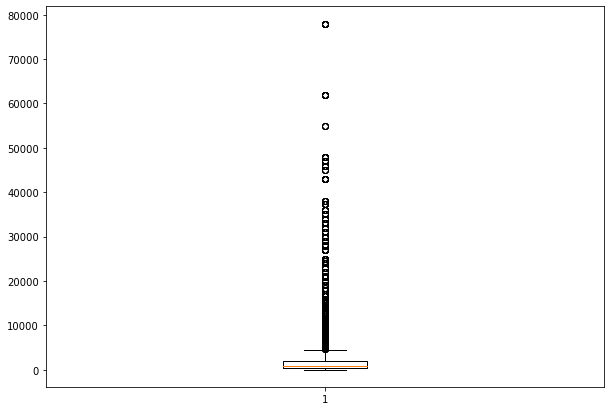

In [44]:
fig = plt.figure(figsize =(10, 7))
plt.boxplot(new_transaction['discounted_price'])
plt.show()

In [45]:
new_transaction[new_transaction.discounted_price>8000].count()

user_id                 1149
transaction_date        1149
product_id              1149
discounted_price        1149
actual_price            1149
discount_percentage     1149
review_id               1149
trimmed_review_title    1149
review_content          1149
dtype: int64

In [46]:
cleaned_transaction = new_transaction[new_transaction.discounted_price<8000]

In [47]:
cleaned_transaction['discounted_price'].count()/new_transaction['discounted_price'].count()*100

90.01130139963487

In [53]:
cleaned_transaction.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10354 entries, 0 to 1464
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   user_id               10354 non-null  object        
 1   transaction_date      10354 non-null  datetime64[ns]
 2   product_id            10354 non-null  object        
 3   discounted_price      10354 non-null  float64       
 4   actual_price          10354 non-null  float64       
 5   discount_percentage   10354 non-null  float64       
 6   review_id             10354 non-null  object        
 7   trimmed_review_title  10354 non-null  object        
 8   review_content        10354 non-null  object        
dtypes: datetime64[ns](1), float64(3), object(5)
memory usage: 808.9+ KB


### Product Detail data

In [48]:
product_detail.describe()

,rating,rating_count
count,1464.000000,1464.000000
mean,4.096585,18282.366803
std,0.291674,42742.207636
min,2.000000,0.000000
25%,4.000000,1179.000000
50%,4.100000,5178.500000
75%,4.300000,17330.750000
max,5.000000,426973.000000


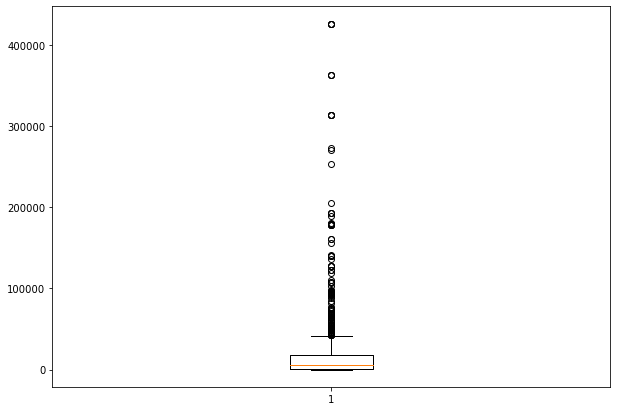

In [49]:
fig = plt.figure(figsize =(10, 7))
plt.boxplot(product_detail['rating_count'])
plt.show()

In [50]:
product_detail[product_detail.rating_count>30000].count()

product_id       203
product_name     203
category         203
rating           203
rating_count     203
about_product    203
img_link         203
product_link     203
main_category    203
sub_category     203
dtype: int64

In [51]:
cleaned_product_detail = product_detail[product_detail.rating_count<35000]

In [52]:
cleaned_product_detail['rating_count'].count()/product_detail['rating_count'].count()*100

89.13934426229508

In [54]:
cleaned_product_detail.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1305 entries, 0 to 1464
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   product_id     1305 non-null   object 
 1   product_name   1305 non-null   object 
 2   category       1305 non-null   object 
 3   rating         1305 non-null   float64
 4   rating_count   1305 non-null   float64
 5   about_product  1305 non-null   object 
 6   img_link       1305 non-null   object 
 7   product_link   1305 non-null   object 
 8   main_category  1305 non-null   object 
 9   sub_category   1305 non-null   object 
dtypes: float64(2), object(8)
memory usage: 112.1+ KB


# 2. Exploratory Data Analysis (EDA)

## 2.1 Transaction data

### 2.1.1 Product price range

In [56]:
cleaned_transaction.describe()

,discounted_price,actual_price,discount_percentage
count,10354.000000,10354.000000,10354.000000
mean,1207.045297,2570.756059,0.494483
std,1456.662788,3186.925352,0.216249
min,39.000000,39.000000,0.000000
25%,299.000000,749.000000,0.360000
50%,649.000000,1499.000000,0.520000
75%,1499.000000,2999.000000,0.650000
max,7999.000000,24999.000000,0.940000


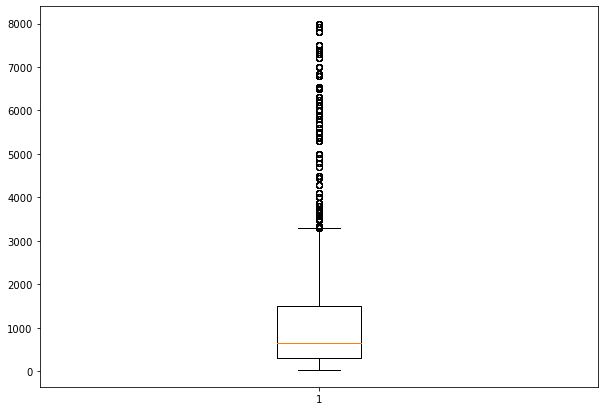

In [57]:
fig = plt.figure(figsize =(10, 7))
plt.boxplot(cleaned_transaction['discounted_price'])
plt.show()

In [58]:
dist_price = cleaned_transaction['discounted_price'].value_counts()
dist_price_freq = pd.DataFrame(dist_price).reset_index()
dist_price_freq.columns = ['discounted_price', 'frequency']
dist_price_freq = dist_price_freq.sort_values(by='discounted_price', ascending=True).reset_index(drop=True)
dist_price_freq

,discounted_price,frequency
0,39.00,24
1,50.00,8
2,57.89,8
3,59.00,40
4,67.00,8
...,...,...
476,7499.00,16
477,7799.00,16
478,7915.00,8
479,7998.00,8


In [63]:
dist_price_freq.to_csv("dist_price_freq.csv", index=False)

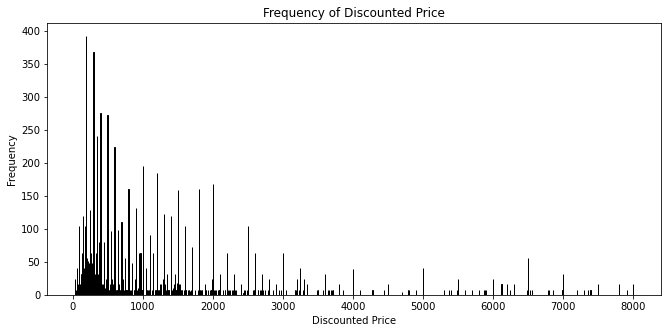

In [64]:
plt.figure(figsize=(11, 5))
plt.bar(dist_price_freq['discounted_price'], dist_price_freq['frequency'], edgecolor='black')
plt.title('Frequency of Discounted Price')
plt.xlabel('Discounted Price')
plt.ylabel('Frequency')
plt.show()

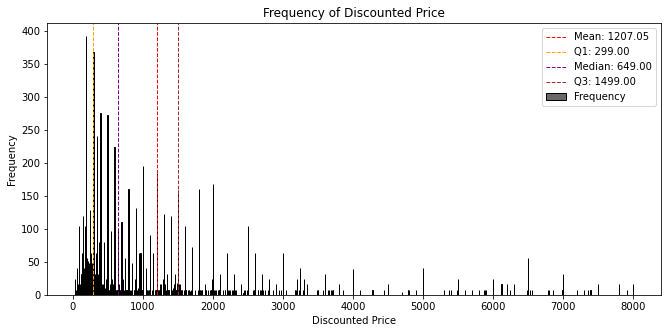

In [155]:
discounts = []
for index, row in dist_price_freq.iterrows():
    discounts.extend([row['discounted_price']] * int(row['frequency']))

mean = np.mean(discounts)
std_dev = np.std(discounts)
q1 = np.percentile(discounts, 25)
median = np.percentile(discounts, 50)
q3 = np.percentile(discounts, 75)

plt.figure(figsize=(11, 5))
plt.bar(dist_price_freq['discounted_price'], dist_price_freq['frequency'], color='dimgrey', edgecolor='black', label='Frequency')

plt.axvline(mean, color='red', linestyle='dashed', linewidth=1, label=f'Mean: {mean:.2f}')
# plt.axvline(mean + std_dev, color='green', linestyle='dashed', linewidth=1, label=f'SD: {std_dev:.2f}')
# plt.axvline(mean - std_dev, color='green', linestyle='dashed', linewidth=1)
plt.axvline(q1, color='orange', linestyle='dashed', linewidth=1, label=f'Q1: {q1:.2f}')
plt.axvline(median, color='purple', linestyle='dashed', linewidth=1, label=f'Median: {median:.2f}')
plt.axvline(q3, color='brown', linestyle='dashed', linewidth=1, label=f'Q3: {q3:.2f}')

plt.title('Frequency of Discounted Price')
plt.xlabel('Discounted Price')
plt.ylabel('Frequency')
plt.legend()

plt.show()

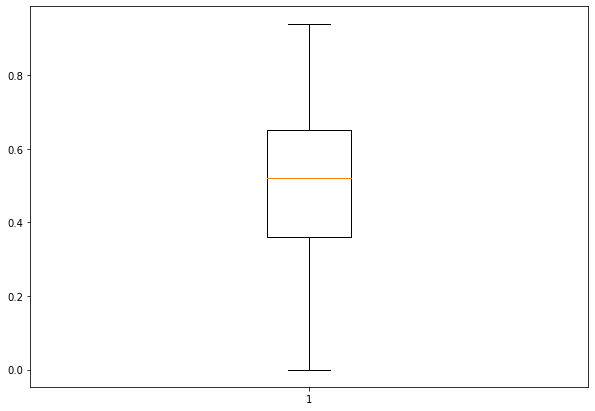

In [61]:
fig = plt.figure(figsize =(10, 7))
plt.boxplot(cleaned_transaction['discount_percentage'])
plt.show()

### 2.1.2 Customer Spending (per customer)

In [65]:
total_spend = cleaned_transaction.groupby('user_id')['discounted_price'].sum().sort_values(ascending=False)

In [66]:
cus_spend = total_spend.value_counts()
cus_spend_freq = pd.DataFrame(cus_spend).reset_index()
cus_spend_freq.columns = ['cus_total_spending', 'frequency']
cus_spend_freq = cus_spend_freq.sort_values(by='cus_total_spending', ascending=True).reset_index(drop=True)
cus_spend_freq

,cus_total_spending,frequency
0,39.0,23
1,50.0,6
2,59.0,6
3,67.0,8
4,69.0,6
...,...,...
682,12698.0,7
683,13298.0,1
684,13524.0,1
685,19497.0,8


In [67]:
cus_spend_freq.describe()

,cus_total_spending,frequency
count,687.000000,687.000000
mean,2062.694207,12.205240
std,2407.635326,22.570333
min,39.000000,1.000000
25%,504.500000,6.000000
50%,1235.000000,8.000000
75%,2681.500000,8.000000
max,20497.000000,247.000000


In [79]:
cus_spend_freq.to_csv("cus_spend_freq.csv", index=False)

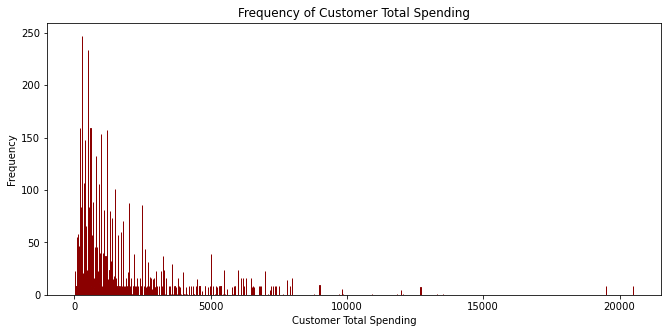

In [78]:
plt.figure(figsize=(11, 5))
plt.bar(cus_spend_freq['cus_total_spending'], cus_spend_freq['frequency'], edgecolor='darkred')
plt.title('Frequency of Customer Total Spending')
plt.xlabel('Customer Total Spending')
plt.ylabel('Frequency')
plt.show()

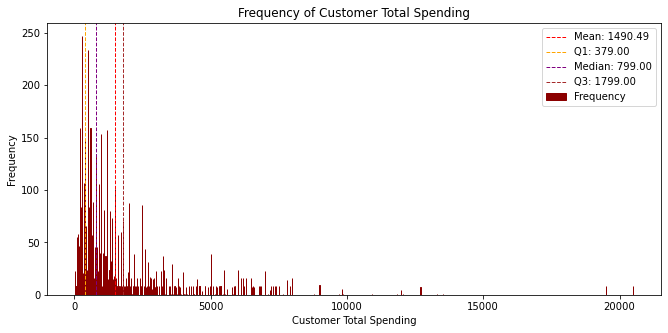

In [154]:
discounts = []
for index, row in cus_spend_freq.iterrows():
    discounts.extend([row['cus_total_spending']] * int(row['frequency']))

mean = np.mean(discounts)
std_dev = np.std(discounts)
q1 = np.percentile(discounts, 25)
median = np.percentile(discounts, 50)
q3 = np.percentile(discounts, 75)

plt.figure(figsize=(11, 5))
plt.bar(cus_spend_freq['cus_total_spending'], cus_spend_freq['frequency'], color='darkred', edgecolor='darkred', label='Frequency')

plt.axvline(mean, color='red', linestyle='dashed', linewidth=1, label=f'Mean: {mean:.2f}')
# plt.axvline(mean + std_dev, color='green', linestyle='dashed', linewidth=1, label=f'SD: {std_dev:.2f}')
# plt.axvline(mean - std_dev, color='green', linestyle='dashed', linewidth=1)
plt.axvline(q1, color='orange', linestyle='dashed', linewidth=1, label=f'Q1: {q1:.2f}')
plt.axvline(median, color='purple', linestyle='dashed', linewidth=1, label=f'Median: {median:.2f}')
plt.axvline(q3, color='brown', linestyle='dashed', linewidth=1, label=f'Q3: {q3:.2f}')

plt.title('Frequency of Customer Total Spending')
plt.xlabel('Customer Total Spending')
plt.ylabel('Frequency')
plt.legend()

plt.show()

In [69]:
total_spend_full_price = cleaned_transaction.groupby('user_id')['actual_price'].sum().sort_values(ascending=False)

In [70]:
product_id = cleaned_transaction['product_id'].value_counts().sort_values(ascending=False)

In [71]:
product_id

B09W5XR9RT    24
B085DTN6R2    24
B09KLVMZ3B    24
B07XLCFSSN    24
B098NS6PVG    24
              ..
B0BN2576GQ     2
B0B94JPY2N     1
B0BQRJ3C47     1
B0B3JSWG81     1
B09XJ1LM7R     1
Name: product_id, Length: 1202, dtype: int64

In [72]:
product_id_df = pd.DataFrame(product_id).reset_index()
product_id_df.columns = ['product_id', 'product_id_sold']
product_id_frequency = product_id_df['product_id_sold'].value_counts().sort_values(ascending=False)
product_id_freq = pd.DataFrame(product_id_frequency).reset_index()
product_id_freq.columns = ['product_id_sold', 'frequency']
product_id_freq

,product_id_sold,frequency
0,8,1078
1,16,65
2,24,22
3,5,8
4,3,7
5,6,6
6,7,5
7,2,4
8,1,4
9,4,2


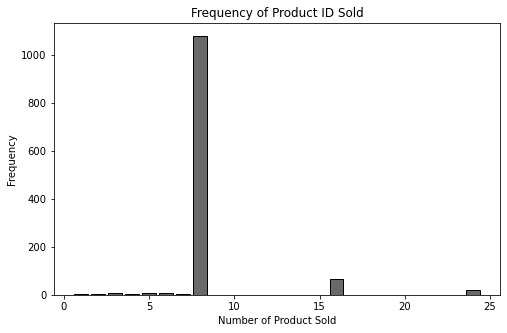

In [105]:
plt.figure(figsize=(8, 5))
plt.bar(product_id_freq['product_id_sold'], product_id_freq['frequency'], color='dimgrey', edgecolor='black')
plt.title('Frequency of Product ID Sold')
plt.xlabel('Number of Product Sold')
plt.ylabel('Frequency')
plt.show()

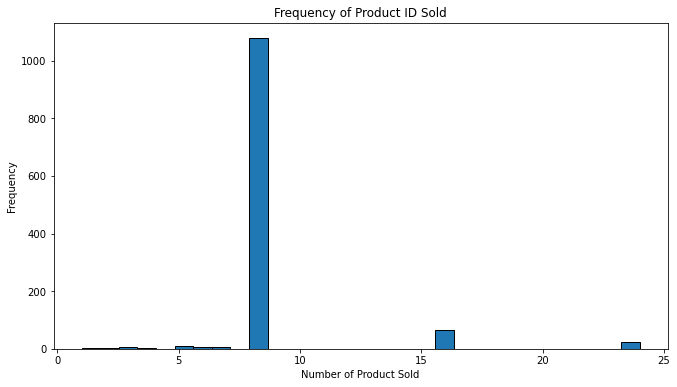

In [94]:
fig = plt.figure(figsize =(11, 6))
plt.hist(product_id, bins=30, edgecolor='black')
plt.title('Frequency of Product ID Sold')
plt.xlabel('Number of Product Sold')
plt.ylabel('Frequency')
plt.show()

### 2.1.3 Customer order (per customer)

In [80]:
user_order = cleaned_transaction['user_id'].value_counts().sort_values(ascending=False)

In [81]:
user_order

AG5DWPD54QGSLWJ6QUFERLPNAX4Q    11
AE55KTFVNXYFD5FPYWP2OUPEYNPQ    11
AECPFYFQVRUWC3KGNLJIOREFP5LQ    10
AHIKJUDTVJ4T6DV6IUGFYZ5LXMPA    10
AF355FTXYAKFH5NYPRTE7SL3WO3Q    10
                                ..
AE5M7SPRDYEU6EPXVXHFGAS3WZXQ     1
AHVJBPTSYB54ISNJO3RFYLHEVUVQ     1
AHN7GHEZKML6JVIVYWBWABE7O5TQ     1
AHHCVLPZJDMVTNXUP3HJK3YIFDFA     1
AHJXXJ6QZSP5VH7GEUWUNOBETADQ     1
Name: user_id, Length: 8385, dtype: int64

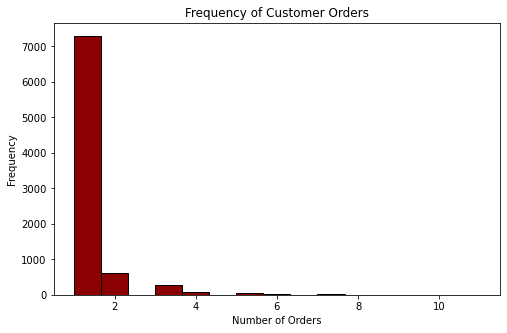

In [102]:
fig = plt.figure(figsize =(8, 5))
plt.hist(user_order,bins=15,color='darkred',edgecolor='black')
plt.title('Frequency of Customer Orders')
plt.xlabel('Number of Orders')
plt.ylabel('Frequency')
plt.show()

In [83]:
user_orders = pd.DataFrame(user_order).reset_index()
user_orders.columns = ['user_id', 'num_of_orders']
user_orders

,user_id,num_of_orders
0,AG5DWPD54QGSLWJ6QUFERLPNAX4Q,11
1,AE55KTFVNXYFD5FPYWP2OUPEYNPQ,11
2,AECPFYFQVRUWC3KGNLJIOREFP5LQ,10
3,AHIKJUDTVJ4T6DV6IUGFYZ5LXMPA,10
4,AF355FTXYAKFH5NYPRTE7SL3WO3Q,10
...,...,...
8380,AE5M7SPRDYEU6EPXVXHFGAS3WZXQ,1
8381,AHVJBPTSYB54ISNJO3RFYLHEVUVQ,1
8382,AHN7GHEZKML6JVIVYWBWABE7O5TQ,1
8383,AHHCVLPZJDMVTNXUP3HJK3YIFDFA,1


In [84]:
order_frequency = user_orders['num_of_orders'].value_counts().sort_values(ascending=False)
user_order_freq = pd.DataFrame(order_frequency).reset_index()
user_order_freq.columns = ['num_of_orders', 'frequency']
user_order_freq

,num_of_orders,frequency
0,1,7294
1,2,626
2,3,282
3,4,81
4,5,47
5,6,20
6,7,18
7,10,7
8,8,7
9,11,2


In [85]:
user_order_2 = new_transaction['user_id'].value_counts().sort_values(ascending=False)

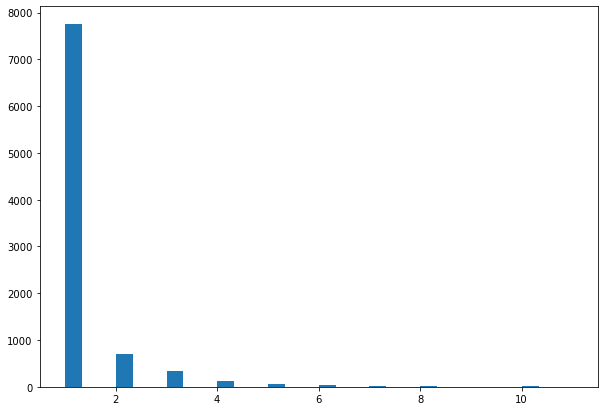

In [86]:
fig = plt.figure(figsize =(8, 5))
plt.hist(user_order_2,bins=30)
plt.show()

### 2.1.4 Product quantity sold

In [87]:
product_id

B09W5XR9RT    24
B085DTN6R2    24
B09KLVMZ3B    24
B07XLCFSSN    24
B098NS6PVG    24
              ..
B0BN2576GQ     2
B0B94JPY2N     1
B0BQRJ3C47     1
B0B3JSWG81     1
B09XJ1LM7R     1
Name: product_id, Length: 1202, dtype: int64

In [88]:
product_sold = pd.DataFrame(product_id).reset_index()
product_sold.columns = ['product_id', 'quantity_sold']
product_sold

,product_id,quantity_sold
0,B09W5XR9RT,24
1,B085DTN6R2,24
2,B09KLVMZ3B,24
3,B07XLCFSSN,24
4,B098NS6PVG,24
...,...,...
1197,B0BN2576GQ,2
1198,B0B94JPY2N,1
1199,B0BQRJ3C47,1
1200,B0B3JSWG81,1


In [89]:
frequency = product_sold['quantity_sold'].value_counts().sort_values(ascending=False)
quantity_sold = pd.DataFrame(frequency).reset_index()
quantity_sold.columns = ['quantity_sold', 'frequency']
quantity_sold

,quantity_sold,frequency
0,8,1078
1,16,65
2,24,22
3,5,8
4,3,7
5,6,6
6,7,5
7,2,4
8,1,4
9,4,2


### 2.1.5 Revenue over the period

In [90]:
orders_over_time = cleaned_transaction.groupby('transaction_date')['discounted_price'].sum()
orders_over_time_df = pd.DataFrame(orders_over_time).reset_index()
orders_over_time_df.columns = ['transaction_date', 'revenue']
orders_over_time_df

,transaction_date,revenue
0,2019-01-01,258694.40
1,2019-01-02,100656.00
2,2019-01-03,147262.64
3,2019-01-04,275482.48
4,2019-01-05,164866.00
5,2019-01-06,57927.20
6,2019-01-07,132040.00
7,2019-01-08,226152.00
8,2019-01-09,108712.00
9,2019-01-10,217344.00


In [91]:
orders_over_time_df.describe()

,revenue
count,5.900000e+01
mean,2.118262e+05
std,1.250706e+05
min,5.792720e+04
25%,1.483902e+05
50%,1.950880e+05
75%,2.482856e+05
max,1.014861e+06


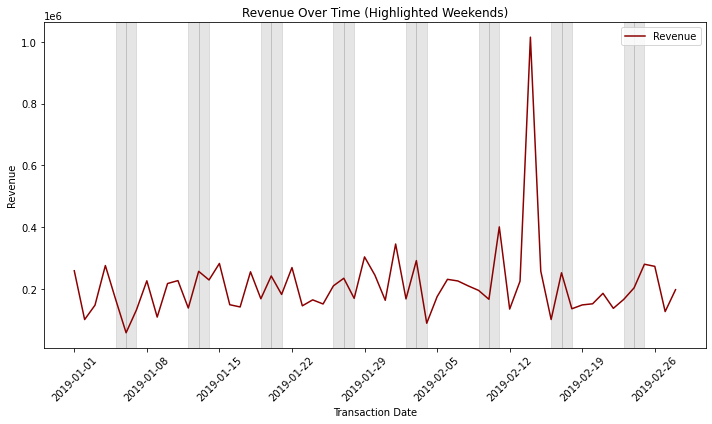

In [107]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(orders_over_time_df['transaction_date'], orders_over_time_df['revenue'], label='Revenue', color='darkred')

weekends = orders_over_time_df[orders_over_time_df['transaction_date'].dt.weekday >= 5]
for weekend in weekends['transaction_date']:
    ax.axvspan(weekend, weekend + pd.Timedelta(days=1), color='grey', alpha=0.2)


ax.xaxis.set_major_locator(mdates.WeekdayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

ax.set_title('Revenue Over Time (Highlighted Weekends)')
ax.set_xlabel('Transaction Date')
ax.set_ylabel('Revenue')

plt.xticks(rotation=45)

plt.legend()
plt.tight_layout()
plt.show()

## 2.2 Product Detail data

### 2.2.1 Product rating score

In [66]:
cleaned_product_detail.describe()

,rating,rating_count
count,1305.000000,1305.000000
mean,4.088123,7711.248276
std,0.300544,8783.389429
min,2.000000,0.000000
25%,3.900000,989.000000
50%,4.100000,3815.000000
75%,4.300000,11976.000000
max,5.000000,34899.000000


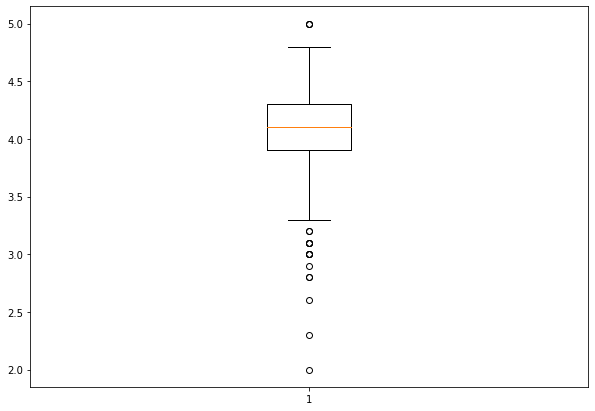

In [67]:
fig = plt.figure(figsize =(10, 7))
plt.boxplot(cleaned_product_detail['rating'])
plt.show()

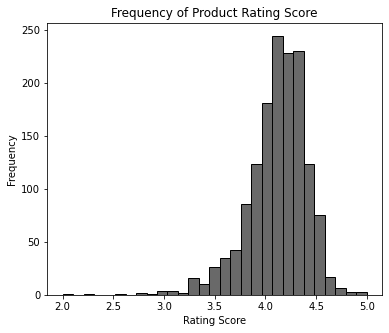

In [167]:
fig = plt.figure(figsize =(6, 5))
plt.hist(product_detail['rating'],bins=29,color='dimgrey',edgecolor='black')
plt.title('Frequency of Product Rating Score')
plt.xlabel('Rating Score')
plt.ylabel('Frequency')
plt.show()

### 2.2.2 Product rating count

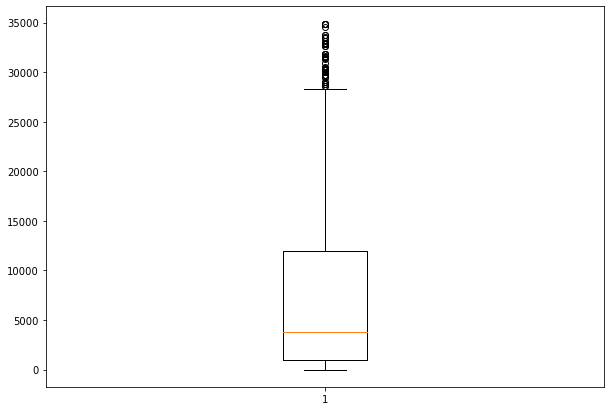

In [69]:
fig = plt.figure(figsize =(10, 7))
plt.boxplot(cleaned_product_detail['rating_count'])
plt.show()

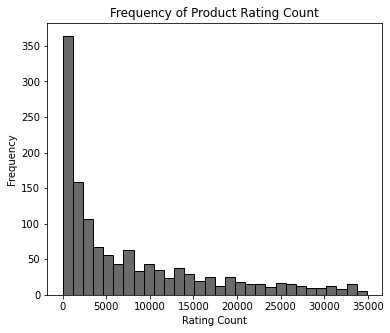

In [116]:
fig = plt.figure(figsize =(6, 5))
plt.hist(cleaned_product_detail['rating_count'],bins=30,color='dimgrey',edgecolor='black')
plt.title('Frequency of Product Rating Count')
plt.xlabel('Rating Count')
plt.ylabel('Frequency')
plt.show()

# 3. In-depth Analysis with Statistical Techniques and Machine Learning

## 3.1 Analysis by charateristics

### 3.1.1 By discounted promo

In [118]:
dist_frequency = cleaned_transaction['discount_percentage'].value_counts()
dist_perc_freq = pd.DataFrame(dist_frequency).reset_index()
dist_perc_freq.columns = ['discount_percentage', 'frequency']
dist_perc_freq = dist_perc_freq.sort_values(by='discount_percentage', ascending=True).reset_index(drop=True)
dist_perc_freq

,discount_percentage,frequency
0,0.00,346
1,0.02,16
2,0.03,24
3,0.04,11
4,0.05,32
...,...,...
87,0.88,48
88,0.89,8
89,0.90,64
90,0.91,40


In [137]:
dist_perc_freq.to_csv("dist_perc_freq.csv", index=False)

In [119]:
dist_perc_freq.describe()

,discount_percentage,frequency
count,92.000000,92.000000
mean,0.465109,112.543478
std,0.267592,86.363074
min,0.000000,8.000000
25%,0.237500,56.000000
50%,0.465000,88.000000
75%,0.692500,146.750000
max,0.940000,435.000000


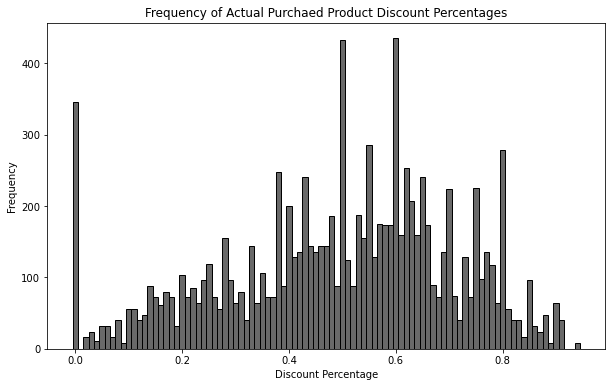

In [136]:
plt.figure(figsize=(10, 6))
plt.bar(dist_perc_freq['discount_percentage'], dist_perc_freq['frequency'], width=0.01, color='dimgrey', edgecolor='black')
plt.title('Frequency of Actual Purchaed Product Discount Percentages')
plt.xlabel('Discount Percentage')
plt.ylabel('Frequency')
plt.show()

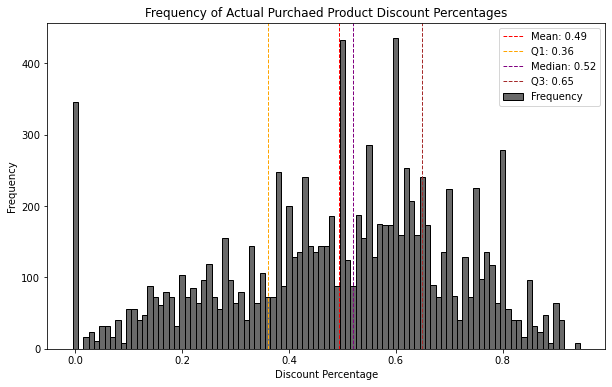

In [148]:
discounts = []
for index, row in dist_perc_freq.iterrows():
    discounts.extend([row['discount_percentage']] * int(row['frequency']))

mean = np.mean(discounts)
std_dev = np.std(discounts)
q1 = np.percentile(discounts, 25)
median = np.percentile(discounts, 50)
q3 = np.percentile(discounts, 75)

plt.figure(figsize=(10, 6))
plt.bar(dist_perc_freq['discount_percentage'], dist_perc_freq['frequency'], width=0.01, color='dimgrey', edgecolor='black', label='Frequency')

plt.axvline(mean, color='red', linestyle='dashed', linewidth=1, label=f'Mean: {mean:.2f}')
# plt.axvline(mean + std_dev, color='green', linestyle='dashed', linewidth=1, label=f'SD: {std_dev:.2f}')
# plt.axvline(mean - std_dev, color='green', linestyle='dashed', linewidth=1)
plt.axvline(q1, color='orange', linestyle='dashed', linewidth=1, label=f'Q1: {q1:.2f}')
plt.axvline(median, color='purple', linestyle='dashed', linewidth=1, label=f'Median: {median:.2f}')
plt.axvline(q3, color='brown', linestyle='dashed', linewidth=1, label=f'Q3: {q3:.2f}')

plt.title('Frequency of Actual Purchaed Product Discount Percentages')
plt.xlabel('Discount Percentage')
plt.ylabel('Frequency')
plt.legend()

plt.show()

### 3.1.2 By product categories (interest)

In [121]:
merged_df = pd.merge(cleaned_transaction, cleaned_product_detail, on='product_id')

In [122]:
order_cat_df = merged_df[['product_id', 'main_category', 'sub_category']].copy()
order_cat_df

,product_id,main_category,sub_category
0,B00LHZWD0C,OfficeProducts,OfficePaperProducts
1,B00LHZWD0C,OfficeProducts,OfficePaperProducts
2,B00LHZWD0C,OfficeProducts,OfficePaperProducts
3,B00LHZWD0C,OfficeProducts,OfficePaperProducts
4,B00LHZWD0C,OfficeProducts,OfficePaperProducts
...,...,...,...
10980,B0B5D39BCD,Electronics,WearableTechnology
10981,B0B5D39BCD,Electronics,WearableTechnology
10982,B0B5D39BCD,Electronics,WearableTechnology
10983,B0B5D39BCD,Electronics,WearableTechnology


In [123]:
order_main_cat = order_cat_df['main_category'].value_counts().sort_values(ascending=False)
order_sub_cat = order_cat_df['sub_category'].value_counts().sort_values(ascending=False)

In [124]:
order_main_cat_df = pd.DataFrame(order_main_cat).reset_index()
order_main_cat_df.columns = ['order_main_cat', 'frequency']
order_main_cat_df

,order_main_cat,frequency
0,Computers&Accessories,4591
1,Home&Kitchen,3204
2,Electronics,2898
3,OfficeProducts,248
4,HomeImprovement,16
5,Toys&Games,8
6,Car&Motorbike,8
7,MusicalInstruments,8
8,Health&PersonalCare,4


In [125]:
order_sub_cat_df = pd.DataFrame(order_sub_cat).reset_index()
order_sub_cat_df.columns = ['order_sub_cat', 'frequency']
order_sub_cat_df

,order_sub_cat,frequency
0,Accessories&Peripherals,4143
1,Kitchen&HomeAppliances,2210
2,Mobiles&Accessories,851
3,"Heating,Cooling&AirQuality",810
4,"HomeTheater,TV&Video",741
5,WearableTechnology,670
6,"Headphones,Earbuds&Accessories",272
7,NetworkingDevices,264
8,OfficePaperProducts,216
9,HomeStorage&Organization,128


### 3.1.3 By Product Rating

In [126]:
product_rating_df = merged_df[['product_id', 'rating','rating_count']].copy()
product_rating_df

,product_id,rating,rating_count
0,B00LHZWD0C,4.5,3785.0
1,B00LHZWD0C,4.5,3785.0
2,B00LHZWD0C,4.5,3785.0
3,B00LHZWD0C,4.5,3785.0
4,B00LHZWD0C,4.5,3785.0
...,...,...,...
10980,B0B5D39BCD,3.8,17831.0
10981,B0B5D39BCD,3.8,17831.0
10982,B0B5D39BCD,3.8,17831.0
10983,B0B5D39BCD,3.8,17831.0


In [127]:
rating_frequency = product_rating_df['rating'].value_counts().sort_values(ascending=False)
rating_frequency_df = pd.DataFrame(rating_frequency).reset_index()
rating_frequency_df.columns = ['rating', 'frequency']
rating_frequency_df = rating_frequency_df.sort_values(by='rating', ascending=True).reset_index(drop=True)
rating_frequency_df

,rating,frequency
0,2.0,2
1,2.3,5
2,2.6,8
3,2.8,16
4,2.9,8
5,3.0,25
6,3.1,25
7,3.2,14
8,3.3,136
9,3.4,80


In [168]:
rating_frequency_df.to_csv('rating_frequency_df.csv', index=False)

In [128]:
rating_frequency_df.describe()

,rating,frequency
count,25.000000,25.000000
mean,3.668000,439.400000
std,0.807114,598.579151
min,2.000000,2.000000
25%,3.100000,16.000000
50%,3.700000,136.000000
75%,4.300000,651.000000
max,5.000000,1698.000000


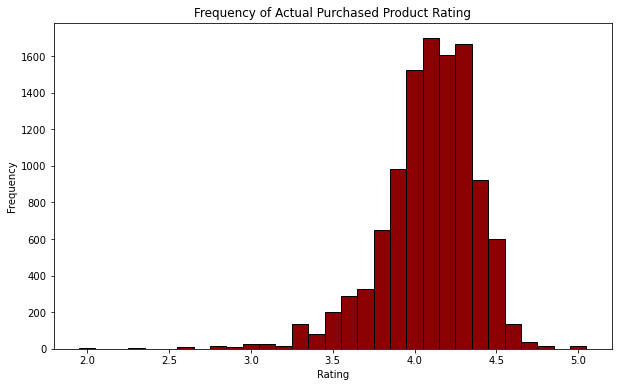

In [135]:
plt.figure(figsize=(10, 6))
plt.bar(rating_frequency_df['rating'], rating_frequency_df['frequency'], width=0.1, color='darkred', edgecolor='black')
plt.title('Frequency of Actual Purchased Product Rating')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

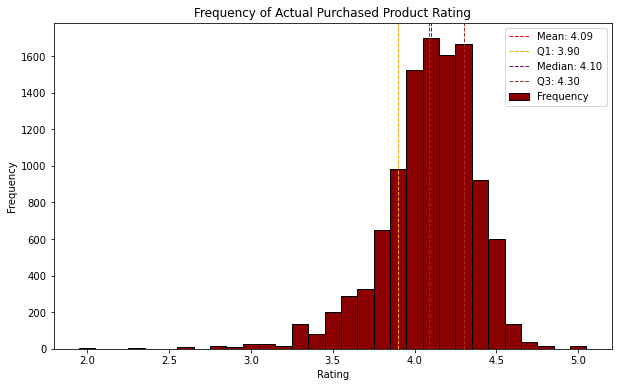

In [149]:
discounts = []
for index, row in rating_frequency_df.iterrows():
    discounts.extend([row['rating']] * int(row['frequency']))

mean = np.mean(discounts)
std_dev = np.std(discounts)
q1 = np.percentile(discounts, 25)
median = np.percentile(discounts, 50)
q3 = np.percentile(discounts, 75)

plt.figure(figsize=(10, 6))
plt.bar(rating_frequency_df['rating'], rating_frequency_df['frequency'], width=0.1, color='darkred', edgecolor='black', label='Frequency')

plt.axvline(mean, color='red', linestyle='dashed', linewidth=1, label=f'Mean: {mean:.2f}')
# plt.axvline(mean + std_dev, color='green', linestyle='dashed', linewidth=1, label=f'SD: {std_dev:.2f}')
# plt.axvline(mean - std_dev, color='green', linestyle='dashed', linewidth=1)
plt.axvline(q1, color='orange', linestyle='dashed', linewidth=1, label=f'Q1: {q1:.2f}')
plt.axvline(median, color='purple', linestyle='dashed', linewidth=1, label=f'Median: {median:.2f}')
plt.axvline(q3, color='brown', linestyle='dashed', linewidth=1, label=f'Q3: {q3:.2f}')

plt.title('Frequency of Actual Purchased Product Rating')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.legend()

plt.show()

## 3.2 Segmentation

### 3.2.1 RFM : Recency, Frequency, Monetary Analysis

The fewer number of days resulted from the more recent customer purchased from the store

In [169]:
cleaned_transaction['diff'] = max(cleaned_transaction['transaction_date']) - cleaned_transaction['transaction_date']
recency = cleaned_transaction.groupby('user_id')['diff'].min()
recency = recency.reset_index()

C:\Users\pocha\AppData\Local\Temp\ipykernel_9432\82748488.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_transaction['diff'] = max(cleaned_transaction['transaction_date']) - cleaned_transaction['transaction_date']


In [170]:
recency

,user_id,diff
0,AE22E2AXODSPNK3EBIHNGYS5LOSA,3 days
1,AE22MK2NXQD3ZARLIOL3SLD4GU6A,46 days
2,AE22Y3KIS7SE6LI3HE2VS6WWPU4Q,39 days
3,AE23RS3W7GZO7LHYKJU6KSKVM4MQ,38 days
4,AE23WGYTUMB5R6JJMBU4V43JIW7Q,22 days
...,...,...
8380,AHZXNS63DN6MZDH3WSKYRLWSG3DA,17 days
8381,AHZYN7O73FJWRPUQGZM5BEAZ3A4A,55 days
8382,AHZZFBL24XXVLW6H44MOB6LBHH5A,39 days
8383,AHZZISWHBQV4TL3MKOJTH22IUNIQ,37 days


In [171]:
recency['diff'] = recency['diff'].dt.days
recency

,user_id,diff
0,AE22E2AXODSPNK3EBIHNGYS5LOSA,3
1,AE22MK2NXQD3ZARLIOL3SLD4GU6A,46
2,AE22Y3KIS7SE6LI3HE2VS6WWPU4Q,39
3,AE23RS3W7GZO7LHYKJU6KSKVM4MQ,38
4,AE23WGYTUMB5R6JJMBU4V43JIW7Q,22
...,...,...
8380,AHZXNS63DN6MZDH3WSKYRLWSG3DA,17
8381,AHZYN7O73FJWRPUQGZM5BEAZ3A4A,55
8382,AHZZFBL24XXVLW6H44MOB6LBHH5A,39
8383,AHZZISWHBQV4TL3MKOJTH22IUNIQ,37


Here calculating the frequency of customers by counting order numbers of each customer, the more the count the more often the customer buys from the store

In [172]:
user_orders

,user_id,num_of_orders
0,AG5DWPD54QGSLWJ6QUFERLPNAX4Q,11
1,AE55KTFVNXYFD5FPYWP2OUPEYNPQ,11
2,AECPFYFQVRUWC3KGNLJIOREFP5LQ,10
3,AHIKJUDTVJ4T6DV6IUGFYZ5LXMPA,10
4,AF355FTXYAKFH5NYPRTE7SL3WO3Q,10
...,...,...
8380,AE5M7SPRDYEU6EPXVXHFGAS3WZXQ,1
8381,AHVJBPTSYB54ISNJO3RFYLHEVUVQ,1
8382,AHN7GHEZKML6JVIVYWBWABE7O5TQ,1
8383,AHHCVLPZJDMVTNXUP3HJK3YIFDFA,1


In [173]:
total_spending = pd.DataFrame(total_spend).reset_index()
total_spending.columns = ['user_id','total_spend']
total_spending

,user_id,total_spend
0,AFVNPALAXLPTQV7PA3A6GG6GNKHQ,20497.0
1,AGNNZL2OXJSOP4LC4PWWYSTCZAAA,20497.0
2,AEI3CRGT2GQUOOD67T5H2NK6J32A,20497.0
3,AGEYI2JEUE752XDEXSTEIO7LJI5A,20497.0
4,AGFWKP74BJOEEMWDPDRITXUIW45A,20497.0
...,...,...
8380,AEETUHPLSOLA55TPPWJWAQ7DZK5A,39.0
8381,AEPLASBTA4EAJJGZ5Z4HSGL32J3Q,39.0
8382,AEEH5DFNKICJXQME6UXNS3P3OM3A,39.0
8383,AGE43ATINMGDC2ODRZNEM4Q2SEVQ,39.0


In [174]:
rfm = pd.merge(recency, user_orders, on='user_id',how='inner')
rfm = pd.merge(rfm, total_spending, on='user_id',how='inner')
rfm.columns = ['user_id','recency','frequency','monetary']
rfm

,user_id,recency,frequency,monetary
0,AE22E2AXODSPNK3EBIHNGYS5LOSA,3,1,1999.0
1,AE22MK2NXQD3ZARLIOL3SLD4GU6A,46,1,3599.0
2,AE22Y3KIS7SE6LI3HE2VS6WWPU4Q,39,1,239.0
3,AE23RS3W7GZO7LHYKJU6KSKVM4MQ,38,1,1999.0
4,AE23WGYTUMB5R6JJMBU4V43JIW7Q,22,1,1187.0
...,...,...,...,...
8380,AHZXNS63DN6MZDH3WSKYRLWSG3DA,17,1,116.0
8381,AHZYN7O73FJWRPUQGZM5BEAZ3A4A,55,1,1099.0
8382,AHZZFBL24XXVLW6H44MOB6LBHH5A,39,2,5198.0
8383,AHZZISWHBQV4TL3MKOJTH22IUNIQ,37,1,99.0


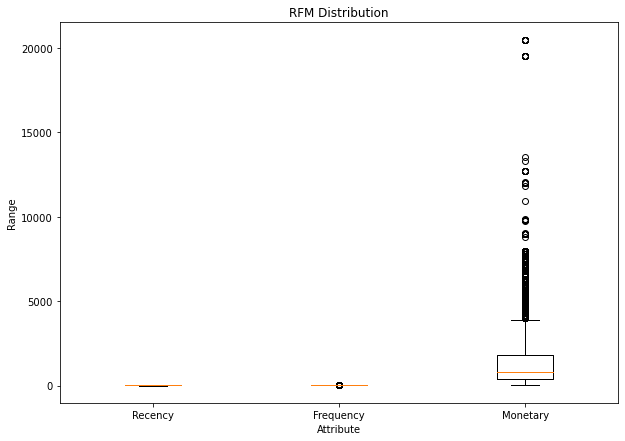

In [175]:
fig = plt.figure(figsize =(10, 7))
plt.boxplot([rfm['recency'],rfm['frequency'],rfm['monetary']])
plt.title('RFM Distribution')
plt.xlabel('Attribute')
plt.ylabel('Range')
plt.xticks([1, 2, 3], ['Recency', 'Frequency', 'Monetary'])
plt.show()

In [176]:
scaler = StandardScaler()
rfm_normalized = rfm[['recency','frequency','monetary']]
rfm_normalized = scaler.fit_transform(rfm_normalized)
rfm_normalized = pd.DataFrame(rfm_normalized)
rfm_normalized.columns = ['Recency','Frequency','Monetary']
rfm_normalized

,Recency,Frequency,Monetary
0,-1.400112,-0.301257,0.269191
1,1.156715,-0.301257,1.116183
2,0.740488,-0.301257,-0.662501
3,0.681026,-0.301257,0.269191
4,-0.270351,-0.301257,-0.160658
...,...,...,...
8380,-0.567657,-0.301257,-0.727613
8381,1.691865,-0.301257,-0.207242
8382,0.740488,0.981649,1.962645
8383,0.621565,-0.301257,-0.736612


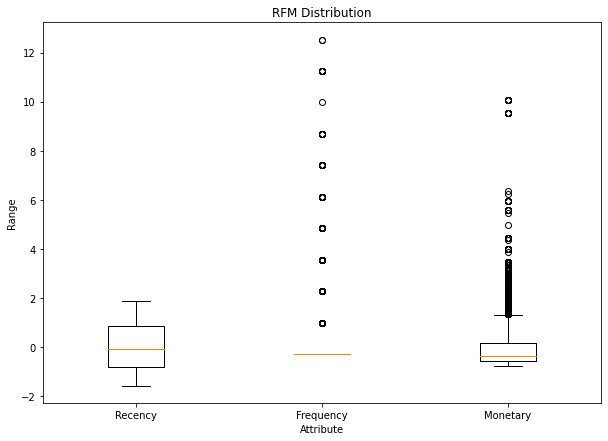

In [177]:
fig = plt.figure(figsize =(10, 7))
plt.boxplot([rfm_normalized['Recency'],rfm_normalized['Frequency'],rfm_normalized['Monetary']])
plt.title('RFM Distribution')
plt.xlabel('Attribute')
plt.ylabel('Range')
plt.xticks([1, 2, 3], ['Recency', 'Frequency', 'Monetary'])
plt.show()

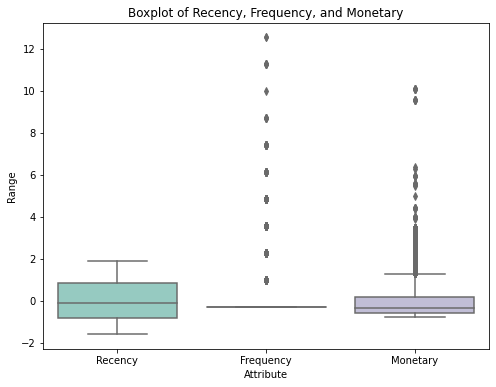

In [178]:
rfm_normalized_melted = rfm_normalized.melt(var_name = 'Attribute', value_name = 'Range')
plt.figure(figsize = (8, 6))
sns.boxplot(x = 'Attribute', y = 'Range', data = rfm_normalized_melted, palette = 'Set3')

plt.title('Boxplot of Recency, Frequency, and Monetary')
plt.xlabel('Attribute')
plt.ylabel('Range')
plt.show()

### 3.2.2 KMeans Clustering

### Elbow Curve

In [179]:
kmeans = KMeans(n_clusters=4, max_iter=50)
kmeans.fit(rfm_normalized)

C:\Users\pocha\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(max_iter=50, n_clusters=4)

In [180]:
ssd = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters = num_clusters, max_iter = 50)
    kmeans.fit(rfm_normalized)
    
    ssd.append(kmeans.inertia_)

C:\Users\pocha\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\pocha\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\pocha\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\pocha\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of

In [181]:
ssd

[18218.719530695496,
 12584.269747090357,
 8698.599894470255,
 7254.365800387019,
 6407.919330041042,
 5359.405342219135,
 4871.748294566456,
 4299.515216217784]

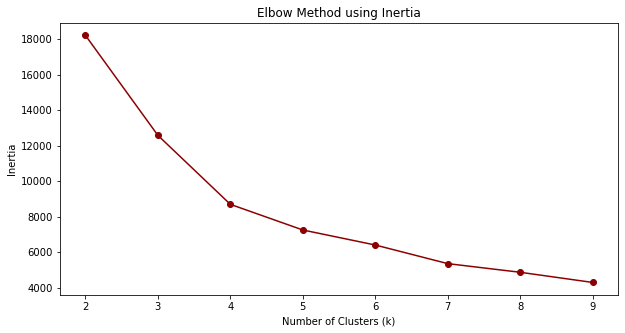

In [188]:
plt.figure(figsize=(10, 5))
plt.plot(range_n_clusters, ssd, color='darkred', marker='o', linestyle='-')
plt.title('Elbow Method using Inertia')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.xticks(range_n_clusters)  # Ensure the x-axis has integer ticks from 0 to 6
plt.show()

To determine the optimal number of clusters, we have to select the value of k at the “elbow” ie the point after which the distortion/inertia starts decreasing in a linear fashion

### Silhouette Analysis

In [190]:
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters = num_clusters, max_iter = 50)
    kmeans.fit(rfm_normalized)
    
    cluster_labels = kmeans.labels_
    
    silhouette_avg = silhouette_score(rfm_normalized, cluster_labels)
    print("For n_cluster={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))

C:\Users\pocha\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_cluster=2, the silhouette score is 0.3642203944818089


C:\Users\pocha\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_cluster=3, the silhouette score is 0.41245086263121483


C:\Users\pocha\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_cluster=4, the silhouette score is 0.46787533608072385


C:\Users\pocha\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_cluster=5, the silhouette score is 0.4755224342625711


C:\Users\pocha\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_cluster=6, the silhouette score is 0.4809336651427054


C:\Users\pocha\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_cluster=7, the silhouette score is 0.37058611074024733


C:\Users\pocha\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_cluster=8, the silhouette score is 0.3890967570602224


C:\Users\pocha\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_cluster=9, the silhouette score is 0.39541515105958636


The silhouette score can help you evaluate the quality of a clustering algorithm and compare different clustering algorithms or parameters. A general rule of thumb is that a silhouette score above 0.5 indicates a good clustering, a silhouette score below 0.25 indicates a bad clustering, and a silhouette score between 0.25 and 0.5 indicates a fair clustering

In [191]:
kmeans = KMeans(n_clusters=6, max_iter=50)
kmeans.fit(rfm_normalized)

C:\Users\pocha\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(max_iter=50, n_clusters=6)

In [217]:
rfm_finalized = rfm_normalized.copy()
rfm_finalized.loc[:,'user_id'] = rfm['user_id']
rfm_finalized

,Recency,Frequency,Monetary,user_id
0,-1.400112,-0.301257,0.269191,AE22E2AXODSPNK3EBIHNGYS5LOSA
1,1.156715,-0.301257,1.116183,AE22MK2NXQD3ZARLIOL3SLD4GU6A
2,0.740488,-0.301257,-0.662501,AE22Y3KIS7SE6LI3HE2VS6WWPU4Q
3,0.681026,-0.301257,0.269191,AE23RS3W7GZO7LHYKJU6KSKVM4MQ
4,-0.270351,-0.301257,-0.160658,AE23WGYTUMB5R6JJMBU4V43JIW7Q
...,...,...,...,...
8380,-0.567657,-0.301257,-0.727613,AHZXNS63DN6MZDH3WSKYRLWSG3DA
8381,1.691865,-0.301257,-0.207242,AHZYN7O73FJWRPUQGZM5BEAZ3A4A
8382,0.740488,0.981649,1.962645,AHZZFBL24XXVLW6H44MOB6LBHH5A
8383,0.621565,-0.301257,-0.736612,AHZZISWHBQV4TL3MKOJTH22IUNIQ


In [218]:
rfm_finalized['Cluster'] = kmeans.labels_
rfm_finalized

,Recency,Frequency,Monetary,user_id,Cluster
0,-1.400112,-0.301257,0.269191,AE22E2AXODSPNK3EBIHNGYS5LOSA,0
1,1.156715,-0.301257,1.116183,AE22MK2NXQD3ZARLIOL3SLD4GU6A,3
2,0.740488,-0.301257,-0.662501,AE22Y3KIS7SE6LI3HE2VS6WWPU4Q,3
3,0.681026,-0.301257,0.269191,AE23RS3W7GZO7LHYKJU6KSKVM4MQ,3
4,-0.270351,-0.301257,-0.160658,AE23WGYTUMB5R6JJMBU4V43JIW7Q,0
...,...,...,...,...,...
8380,-0.567657,-0.301257,-0.727613,AHZXNS63DN6MZDH3WSKYRLWSG3DA,0
8381,1.691865,-0.301257,-0.207242,AHZYN7O73FJWRPUQGZM5BEAZ3A4A,3
8382,0.740488,0.981649,1.962645,AHZZFBL24XXVLW6H44MOB6LBHH5A,1
8383,0.621565,-0.301257,-0.736612,AHZZISWHBQV4TL3MKOJTH22IUNIQ,3


Text(0.5, 1.0, 'Boxplot of Recency in 6 Clusters')

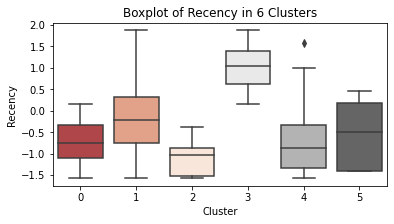

In [221]:
plt.figure(figsize=(6, 3))
sns.boxplot(x = 'Cluster', y = 'Recency', data = rfm_finalized, palette='RdGy')
plt.title('Boxplot of Recency in 6 Clusters')

Text(0.5, 1.0, 'Boxplot of Recency in 6 Clusters')

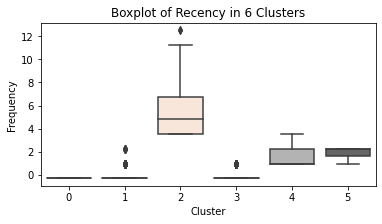

In [222]:
plt.figure(figsize=(6, 3))
sns.boxplot(x = 'Cluster', y = 'Frequency', data = rfm_finalized, palette='RdGy')
plt.title('Boxplot of Recency in 6 Clusters')

Text(0.5, 1.0, 'Boxplot of Recency in 6 Clusters')

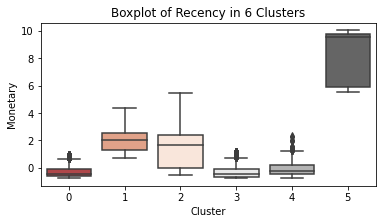

In [223]:
plt.figure(figsize=(6, 3))
sns.boxplot(x = 'Cluster', y = 'Monetary', data = rfm_finalized, palette='RdGy')
plt.title('Boxplot of Recency in 6 Clusters')

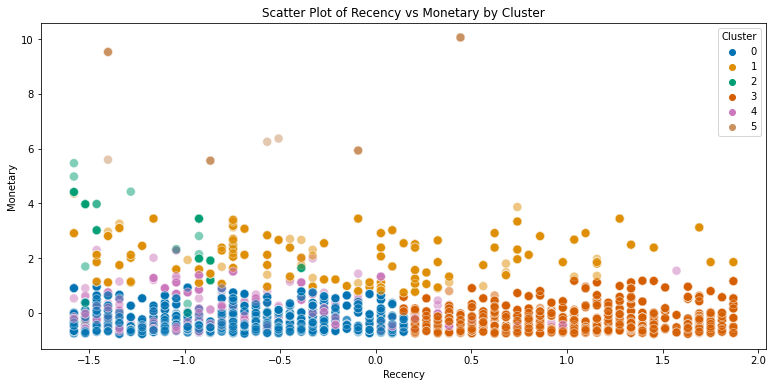

In [197]:
plt.figure(figsize=(13, 6))
sns.scatterplot(data=rfm_finalized, x='Recency', y='Monetary', hue='cluster', palette='colorblind', s=80, alpha=0.5)

plt.title('Scatter Plot of Recency vs Monetary by Cluster')
plt.xlabel('Recency')
plt.ylabel('Monetary')
plt.legend(title='Cluster')
plt.show()

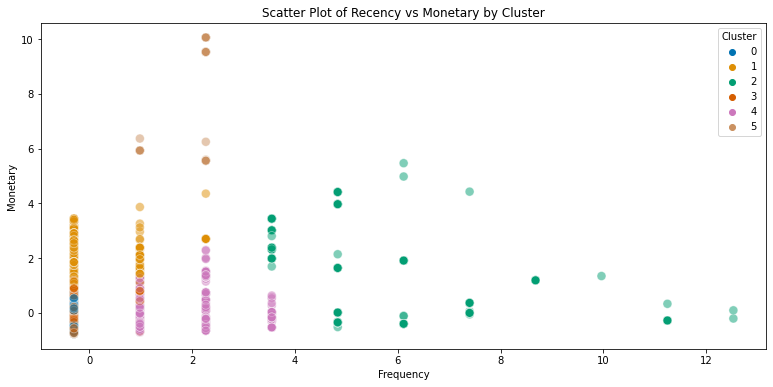

In [198]:
plt.figure(figsize=(13, 6))
sns.scatterplot(data=rfm_finalized, x='Frequency', y='Monetary', hue='cluster', palette='colorblind', s=80, alpha=0.5)

plt.title('Scatter Plot of Recency vs Monetary by Cluster')
plt.xlabel('Frequency')
plt.ylabel('Monetary')
plt.legend(title='Cluster')
plt.show()

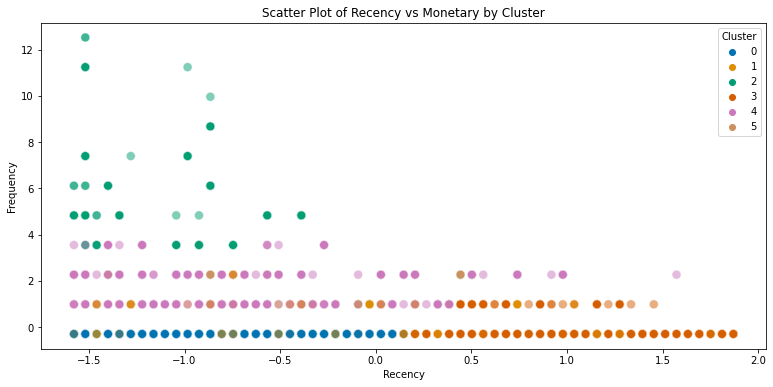

In [199]:
plt.figure(figsize=(13, 6))
sns.scatterplot(data=rfm_finalized, x='Recency', y='Frequency', hue='cluster', palette='colorblind', s=80, alpha=0.5)

plt.title('Scatter Plot of Recency vs Monetary by Cluster')
plt.xlabel('Recency')
plt.ylabel('Frequency')
plt.legend(title='Cluster')
plt.show()

### 3.2.2 Hierarchical Clustering

In [224]:
rfm_normalized_2 = rfm_normalized.copy()

In [225]:
Z = linkage(rfm_normalized_2, method='ward')

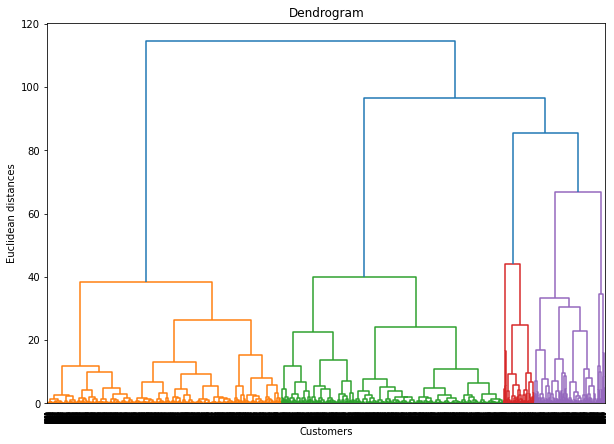

In [226]:
plt.figure(figsize=(10, 7))
dendrogram(Z)
plt.title('Dendrogram')
plt.xlabel('Customers')
plt.ylabel('Euclidean distances')
plt.show()

In [227]:
rfm_normalized_2['Cluster'] = fcluster(Z, t=6, criterion='maxclust')

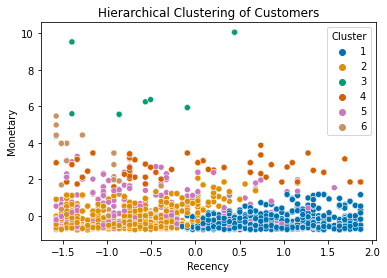

In [228]:
sns.scatterplot(data=rfm_normalized_2, x='Recency', y='Monetary', hue='Cluster', palette='colorblind')
plt.title('Hierarchical Clustering of Customers')
plt.xlabel('Recency')
plt.ylabel('Monetary')
plt.show()

### 3.2.3 Cohort Analysis

In [229]:
cleaned_transaction_2 = cleaned_transaction.copy()

In [230]:
def get_week(x):
    return x - pd.DateOffset(days=x.weekday())

# Apply function to get the start of the week for each transaction date
cleaned_transaction_2['transaction_week'] = cleaned_transaction_2['transaction_date'].apply(get_week)

# Calculate the cohort week for each user (i.e., the earliest week they made a transaction)
cleaned_transaction_2['cohort_week'] = cleaned_transaction_2.groupby('user_id')['transaction_week'].transform('min')

In [231]:
# Function to extract year and week number
def get_year_week(date):
    return date.isocalendar().year, date.isocalendar().week

# Extract year and week number for transaction and cohort weeks
cleaned_transaction_2['transaction_year'], cleaned_transaction_2['transaction_week_num'] = zip(*cleaned_transaction_2['transaction_week'].apply(get_year_week))
cleaned_transaction_2['cohort_year'], cleaned_transaction_2['cohort_week_num'] = zip(*cleaned_transaction_2['cohort_week'].apply(get_year_week))

# Calculate the difference in weeks
cleaned_transaction_2['year_diff'] = cleaned_transaction_2['transaction_year'] - cleaned_transaction_2['cohort_year']
cleaned_transaction_2['week_diff'] = cleaned_transaction_2['transaction_week_num'] - cleaned_transaction_2['cohort_week_num']
cleaned_transaction_2['cohort_index'] = cleaned_transaction_2['year_diff'] * 52 + cleaned_transaction_2['week_diff'] + 1

In [232]:
cleaned_transaction_2

,user_id,transaction_date,product_id,discounted_price,actual_price,discount_percentage,review_id,trimmed_review_title,review_content,diff,transaction_week,cohort_week,transaction_year,transaction_week_num,cohort_year,cohort_week_num,year_diff,week_diff,cohort_index
0,AEAD2LHI2R3QVR3AQKOPB523SVUA,2019-01-01,B00LHZWD0C,252.0,315.0,0.20,R1ERT7AXR5RE2,Good note book,Nice notebook with sufficiently good quality p...,58 days,2018-12-31,2018-12-31,2019,1,2019,1,0,0,1
0,AGHZS375UQZ6XK6BYQCZ2YJ4TX6A,2019-01-01,B00LHZWD0C,252.0,315.0,0.20,R1OBNL676FOQDS,Five Star Product,Nice notebook with sufficiently good quality p...,58 days,2018-12-31,2018-12-31,2019,1,2019,1,0,0,1
0,AE3EZWQC4YBZLYGELTAF4RPD4YVQ,2019-01-01,B00LHZWD0C,252.0,315.0,0.20,R3FYTFWQDO4FYY,Nothing,Nice notebook with sufficiently good quality p...,58 days,2018-12-31,2018-12-31,2019,1,2019,1,0,0,1
0,AGHNTOZPHJSNZXAV6VXZ55QQS2VA,2019-01-01,B00LHZWD0C,252.0,315.0,0.20,R2VQ9R0Y5A3Y9M,Not bad,Nice notebook with sufficiently good quality p...,58 days,2018-12-31,2018-12-31,2019,1,2019,1,0,0,1
0,AE34CJ4WMOVB26TU5H42L74U5DGA,2019-01-01,B00LHZWD0C,252.0,315.0,0.20,R88P3ETAAIQ4M,decent buy,Nice notebook with sufficiently good quality p...,58 days,2018-12-31,2018-12-31,2019,1,2019,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1464,AHPOQQONRLZMHYLDKYP5SQOKRIEA,2019-02-28,B0B5D39BCD,1999.0,7990.0,0.75,R1O1T0NB6M5CU4,nice product,[Update: Sept 29] boAt seems to have heard the...,0 days,2019-02-25,2019-01-28,2019,9,2019,5,0,4,5
1464,AGDD5ACY3AGTMTVBQOC3DMUR6REA,2019-02-28,B0B5D39BCD,1999.0,7990.0,0.75,RY95PJLUIT03E,Good product,[Update: Sept 29] boAt seems to have heard the...,0 days,2019-02-25,2019-01-28,2019,9,2019,5,0,4,5
1464,AFZV4ISJSNGDUD5TU3VYMTYQ5JGA,2019-02-28,B0B5D39BCD,1999.0,7990.0,0.75,R2HMI9LDLJ1S2Y,Super value for money,[Update: Sept 29] boAt seems to have heard the...,0 days,2019-02-25,2019-01-28,2019,9,2019,5,0,4,5
1464,AGKPRGZCV5XK7ZNVLQWUGRB6CVVQ,2019-02-28,B0B5D39BCD,1999.0,7990.0,0.75,R216CF66UYJR2A,Awesome product,[Update: Sept 29] boAt seems to have heard the...,0 days,2019-02-25,2019-01-28,2019,9,2019,5,0,4,5


### Cohort: User number & Retention Rate

In [233]:
# Create cohort data by week
cohort_data = cleaned_transaction_2.groupby(['cohort_week', 'cohort_index'])['user_id'].apply(pd.Series.nunique).reset_index()

# Pivot table to get cohort count
cohort_count = cohort_data.pivot_table(index='cohort_week',
                                       columns='cohort_index',
                                       values='user_id')

# Display the cohort count DataFrame
cohort_count

cohort_index,1,2,3,4,5,6,7,8,9
cohort_week,,,,,,,,,
2018-12-31,942.0,46.0,50.0,63.0,93.0,55.0,104.0,46.0,45.0
2019-01-07,1009.0,46.0,52.0,68.0,54.0,71.0,42.0,27.0,NaN
2019-01-14,1066.0,62.0,35.0,11.0,67.0,28.0,18.0,NaN,NaN
2019-01-21,982.0,36.0,40.0,70.0,15.0,54.0,NaN,NaN,NaN
2019-01-28,945.0,27.0,39.0,9.0,20.0,NaN,NaN,NaN,NaN
2019-02-04,877.0,13.0,45.0,8.0,NaN,NaN,NaN,NaN,NaN
2019-02-11,1236.0,45.0,31.0,NaN,NaN,NaN,NaN,NaN,NaN
2019-02-18,828.0,16.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-02-25,500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [234]:
cohort_size = cohort_count.iloc[:,0]
retention = cohort_count.divide(cohort_size, axis = 0)
retention.round(3) * 100

cohort_index,1,2,3,4,5,6,7,8,9
cohort_week,,,,,,,,,
2018-12-31,100.0,4.9,5.3,6.7,9.9,5.8,11.0,4.9,4.8
2019-01-07,100.0,4.6,5.2,6.7,5.4,7.0,4.2,2.7,NaN
2019-01-14,100.0,5.8,3.3,1.0,6.3,2.6,1.7,NaN,NaN
2019-01-21,100.0,3.7,4.1,7.1,1.5,5.5,NaN,NaN,NaN
2019-01-28,100.0,2.9,4.1,1.0,2.1,NaN,NaN,NaN,NaN
2019-02-04,100.0,1.5,5.1,0.9,NaN,NaN,NaN,NaN,NaN
2019-02-11,100.0,3.6,2.5,NaN,NaN,NaN,NaN,NaN,NaN
2019-02-18,100.0,1.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-02-25,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


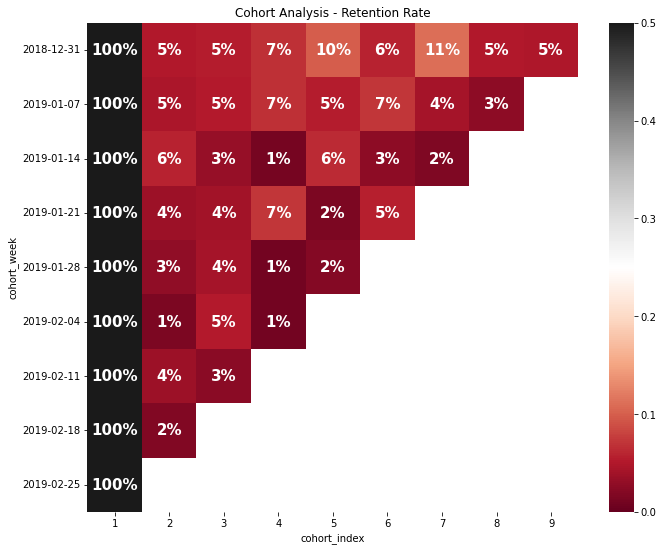

In [252]:
plt.figure(figsize = (11,9))
plt.title('Cohort Analysis - Retention Rate')
ax = sns.heatmap(data = retention, 
            annot = True, 
            fmt = '.0%', 
            vmin = 0.0,
            vmax = 0.5,
            cmap = "RdGy",
            annot_kws={"size": 15, "weight": "bold"})
ax.set_yticklabels([label.get_text().split('T')[0] for label in ax.get_yticklabels()])
plt.show()

### Average Quantity Sold

In [242]:
cleaned_transaction_2['quantity'] = count['user_id'].apply(lambda x: len(x))

In [243]:
cohort_data2 = cleaned_transaction_2.groupby(['cohort_week', 'cohort_index'])['quantity'].mean().reset_index()
average_quantity  = cohort_data2.pivot_table(index = 'cohort_week',
                                            columns = 'cohort_index',
                                       values = 'quantity').round(1)
average_quantity

cohort_index,1,2,3,4,5,6,7,8,9
cohort_week,,,,,,,,,
2018-12-31,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0
2019-01-07,8.0,7.9,8.0,8.0,8.0,8.0,8.0,8.0,NaN
2019-01-14,7.9,7.8,7.7,8.0,7.8,8.0,8.0,NaN,NaN
2019-01-21,8.0,8.0,8.0,8.0,8.0,8.0,NaN,NaN,NaN
2019-01-28,7.9,8.0,8.0,8.0,8.0,NaN,NaN,NaN,NaN
2019-02-04,7.9,8.0,8.0,8.0,NaN,NaN,NaN,NaN,NaN
2019-02-11,7.9,8.0,8.0,NaN,NaN,NaN,NaN,NaN,NaN
2019-02-18,8.0,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-02-25,7.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


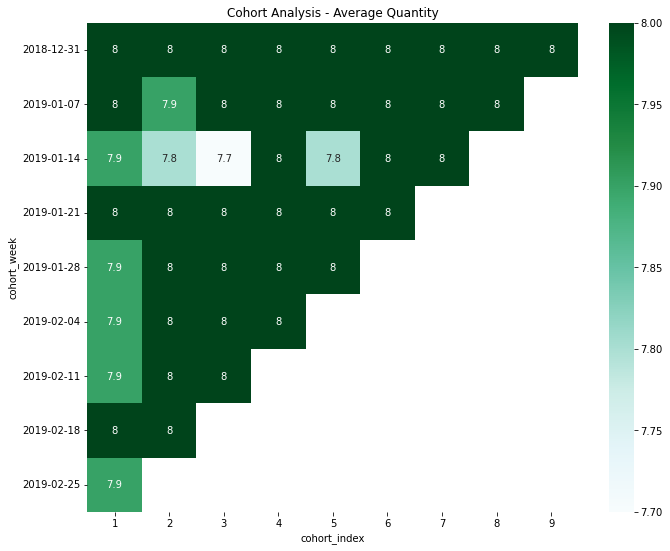

In [244]:
plt.figure(figsize = (11,9))
plt.title('Cohort Analysis - Average Quantity')
ax = sns.heatmap(data = average_quantity, 
            annot = True, 
            cmap = "BuGn")
ax.set_yticklabels([label.get_text().split('T')[0] for label in ax.get_yticklabels()])
plt.show()

### Average Revenues

In [245]:
cohort_data3 = cleaned_transaction_2.groupby(['cohort_week', 'cohort_index'])['discounted_price'].mean().reset_index()
average_sales  = cohort_data3.pivot_table(index = 'cohort_week',
                                           columns = 'cohort_index',
                                      values = 'discounted_price').round(1)
average_sales

cohort_index,1,2,3,4,5,6,7,8,9
cohort_week,,,,,,,,,
2018-12-31,1039.2,839.5,814.2,428.0,628.1,700.9,769.5,1056.0,391.2
2019-01-07,1212.5,1149.6,1555.9,606.6,505.7,586.9,184.8,329.7,NaN
2019-01-14,1235.7,608.6,1506.5,1148.2,1104.8,1481.5,1148.9,NaN,NaN
2019-01-21,1140.1,2152.5,578.8,967.7,1011.5,564.8,NaN,NaN,NaN
2019-01-28,1487.1,1430.9,1517.8,369.1,1233.4,NaN,NaN,NaN,NaN
2019-02-04,1247.0,569.1,350.3,367.8,NaN,NaN,NaN,NaN,NaN
2019-02-11,1595.5,537.3,2712.4,NaN,NaN,NaN,NaN,NaN,NaN
2019-02-18,1161.6,376.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-02-25,1321.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [258]:
def format_func(x, pos):
    if x >= 1e3:
        return f'{x/1e3:.0f}k'
    return f'{x:.0f}'

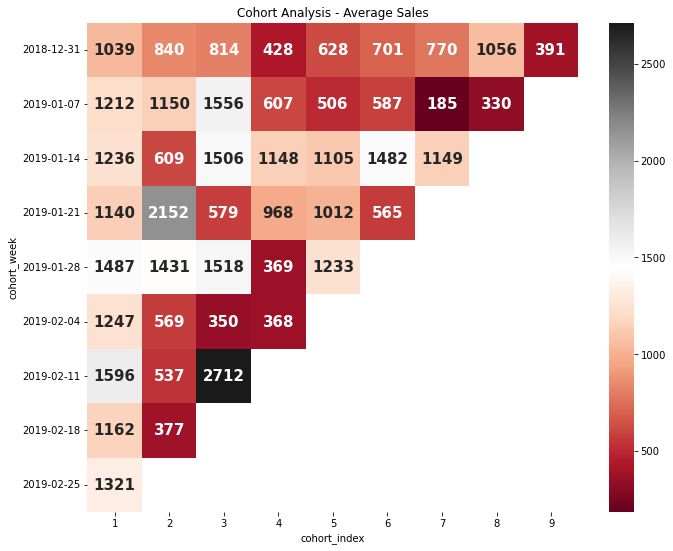

In [262]:
plt.figure(figsize = (11,9))
plt.title('Cohort Analysis - Average Sales')
ax = sns.heatmap(data = average_sales, 
            annot = True,
            fmt='.0f',     
            cmap = "RdGy",
            annot_kws={"size": 15, "weight": "bold"})
ax.set_yticklabels([label.get_text().split('T')[0] for label in ax.get_yticklabels()])
plt.show()

### 3.2.4 Discounted Price, Rating Scoring and Rating Counts Relationship

In [263]:
quantity_rating = merged_df[['product_id','discounted_price','rating','rating_count','main_category','sub_category']].copy()
quantity_rating

,product_id,discounted_price,rating,rating_count,main_category,sub_category
0,B00LHZWD0C,252.0,4.5,3785.0,OfficeProducts,OfficePaperProducts
1,B00LHZWD0C,252.0,4.5,3785.0,OfficeProducts,OfficePaperProducts
2,B00LHZWD0C,252.0,4.5,3785.0,OfficeProducts,OfficePaperProducts
3,B00LHZWD0C,252.0,4.5,3785.0,OfficeProducts,OfficePaperProducts
4,B00LHZWD0C,252.0,4.5,3785.0,OfficeProducts,OfficePaperProducts
...,...,...,...,...,...,...
10980,B0B5D39BCD,1999.0,3.8,17831.0,Electronics,WearableTechnology
10981,B0B5D39BCD,1999.0,3.8,17831.0,Electronics,WearableTechnology
10982,B0B5D39BCD,1999.0,3.8,17831.0,Electronics,WearableTechnology
10983,B0B5D39BCD,1999.0,3.8,17831.0,Electronics,WearableTechnology


In [264]:
quantity_rating['product_id'].value_counts()

B077Z65HSD    72
B09W5XR9RT    72
B08CF3D7QR    72
B08DDRGWTJ    72
B096MSW6CT    72
              ..
B0BPJBTB3F     2
B0B94JPY2N     1
B0BQRJ3C47     1
B0B3JSWG81     1
B09XJ1LM7R     1
Name: product_id, Length: 1072, dtype: int64

In [265]:
grouped_df = quantity_rating.groupby('product_id').agg(
    quantity=('product_id', 'size'),
    discounted_price=('discounted_price', 'first'),
    rating=('rating', 'first'),
    rating_count=('rating_count', 'first'),
    main_category=('main_category', 'first'),
    sub_category=('sub_category', 'first')
).reset_index()
grouped_df

,product_id,quantity,discounted_price,rating,rating_count,main_category,sub_category
0,B002PD61Y4,32,507.0,4.1,8131.0,Computers&Accessories,NetworkingDevices
1,B003B00484,8,399.0,4.3,27201.0,Electronics,GeneralPurposeBatteries&BatteryChargers
2,B003L62T7W,8,279.0,4.3,31534.0,Computers&Accessories,Accessories&Peripherals
3,B005LJQMCK,8,416.0,4.2,30023.0,Electronics,"HomeTheater,TV&Video"
4,B005LJQMZC,8,486.0,4.2,30023.0,Electronics,"HomeTheater,TV&Video"
...,...,...,...,...,...,...,...
1067,B0BPBXNQQT,8,799.0,4.3,70.0,Home&Kitchen,"Heating,Cooling&AirQuality"
1068,B0BPCJM7TB,8,259.0,4.0,43.0,Home&Kitchen,Kitchen&HomeAppliances
1069,B0BPJBTB3F,2,1299.0,2.0,2.0,Home&Kitchen,"Heating,Cooling&AirQuality"
1070,B0BQ3K23Y1,8,279.0,4.8,28.0,Home&Kitchen,Kitchen&HomeAppliances


In [266]:
X = grouped_df[['discounted_price', 'rating', 'rating_count']]
y = grouped_df['quantity']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("Coefficients:", model.coef_)
print("Intercept:", model.intercept_)

print("Mean squared error:", mean_squared_error(y_test, y_pred))
print("R^2 score:", r2_score(y_test, y_pred))

Coefficients: [-6.79168952e-04  1.77044485e+00  1.39107796e-04]
Intercept: 2.922544046250149
Mean squared error: 97.81816752062149
R^2 score: 0.03267289631742254


In [267]:
X = grouped_df[['discounted_price', 'rating', 'rating_count']]
X = sm.add_constant(X)
y = grouped_df['quantity']

model = sm.OLS(y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               quantity   R-squared:                       0.031
Model:                            OLS   Adj. R-squared:                  0.028
Method:                 Least Squares   F-statistic:                     11.26
Date:                Thu, 01 Aug 2024   Prob (F-statistic):           2.83e-07
Time:                        02:38:49   Log-Likelihood:                -3970.0
No. Observations:                1072   AIC:                             7948.
Df Residuals:                    1068   BIC:                             7968.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                4.1229      3.888  

### 3.2.5 Sentiment Analysis

In [268]:
review_df = merged_df[['product_id','main_category','sub_category','trimmed_review_title','review_content']].copy()
review_df

,product_id,main_category,sub_category,trimmed_review_title,review_content
0,B00LHZWD0C,OfficeProducts,OfficePaperProducts,Good note book,Nice notebook with sufficiently good quality p...
1,B00LHZWD0C,OfficeProducts,OfficePaperProducts,Five Star Product,Nice notebook with sufficiently good quality p...
2,B00LHZWD0C,OfficeProducts,OfficePaperProducts,Nothing,Nice notebook with sufficiently good quality p...
3,B00LHZWD0C,OfficeProducts,OfficePaperProducts,Not bad,Nice notebook with sufficiently good quality p...
4,B00LHZWD0C,OfficeProducts,OfficePaperProducts,decent buy,Nice notebook with sufficiently good quality p...
...,...,...,...,...,...
10980,B0B5D39BCD,Electronics,WearableTechnology,nice product,[Update: Sept 29] boAt seems to have heard the...
10981,B0B5D39BCD,Electronics,WearableTechnology,Good product,[Update: Sept 29] boAt seems to have heard the...
10982,B0B5D39BCD,Electronics,WearableTechnology,Super value for money,[Update: Sept 29] boAt seems to have heard the...
10983,B0B5D39BCD,Electronics,WearableTechnology,Awesome product,[Update: Sept 29] boAt seems to have heard the...


In [269]:
def get_sentiment(text):
    analysis = TextBlob(text)
    return analysis.sentiment.polarity

In [270]:
review_df['sentiment'] = review_df['trimmed_review_title'].apply(get_sentiment)

In [271]:
grouped_by_main_category = review_df.groupby('main_category')['sentiment'].mean().sort_values(ascending=False).reset_index()
print("Average Sentiment by Product Main Category:")
grouped_by_main_category

Average Sentiment by Product Main Category:


,main_category,sentiment
0,OfficeProducts,0.444898
1,Toys&Games,0.430208
2,Computers&Accessories,0.410289
3,MusicalInstruments,0.410000
4,Home&Kitchen,0.395036
5,Electronics,0.385003
6,Car&Motorbike,0.350000
7,Health&PersonalCare,0.250000
8,HomeImprovement,0.107969


In [272]:
grouped_by_sub_category = review_df.groupby('sub_category')['sentiment'].mean().sort_values(ascending=False).reset_index()
print("Average Sentiment by Product Sub-Category:")
grouped_by_sub_category

Average Sentiment by Product Sub-Category:


,sub_category,sentiment
0,PowerAccessories,0.765625
1,Accessories,0.549375
2,OfficeElectronics,0.543542
3,CraftMaterials,0.518021
4,Cameras&Photography,0.443710
5,NetworkingDevices,0.430494
6,OfficePaperProducts,0.430284
7,Arts&Crafts,0.430208
8,Monitors,0.423958
9,Mobiles&Accessories,0.420649


In [273]:
grouped_by_product = review_df.groupby('product_id')['sentiment'].mean().sort_values(ascending=False).reset_index()
print("\nAverage Sentiment by Product ID:")
grouped_by_product


Average Sentiment by Product ID:


,product_id,sentiment
0,B0BQRJ3C47,1.000000
1,B09NL7LBWT,0.767708
2,B0083T231O,0.765625
3,B07QZ3CZ48,0.762500
4,B09YLYB9PB,0.760000
...,...,...
1067,B0BNDGL26T,-0.087500
1068,B0B7NWGXS6,-0.100000
1069,B07DZ986Q2,-0.122917
1070,B09LV13JFB,-0.168000


TextBlob Sentiment Scores:

Polarity: Ranges from -1 to 1.
* -1: Very negative sentiment.
* 0: Neutral sentiment.
* 1: Very positive sentiment.

Subjectivity: Ranges from 0 to 1.
* 0: Objective (factual).
* 1: Subjective (opinion-based).

Each sentiment score from the get_sentiment function represents how positive or negative the review title is:
* Positive Sentiment (0 to 1): Indicates that the review title expresses positive feelings about the product.
* Negative Sentiment (-1 to 0): Indicates that the review title expresses negative feelings about the product.
* Neutral Sentiment (close to 0): Indicates that the review title does not express strong feelings either way.

In [274]:
nltk.download('punkt')
nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    tokens = word_tokenize(text.lower())
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word.isalpha()]
    return ' '.join(tokens)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\pocha\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\pocha\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [278]:
positive_reviews = review_df[review_df['sentiment'] > 0]['trimmed_review_title']
negative_reviews = review_df[review_df['sentiment'] < 0]['trimmed_review_title']

positive_text = ' '.join(positive_reviews)
negative_text = ' '.join(negative_reviews)

specific_stopwords = {'product','products'}
stop_words = set(STOPWORDS).union(specific_stopwords)

positive_wc = WordCloud(width=800, height=400, background_color='white', stopwords=stop_words).generate(positive_text)
negative_wc = WordCloud(width=800, height=400, background_color='black', colormap='Reds', stopwords=stop_words).generate(negative_text)

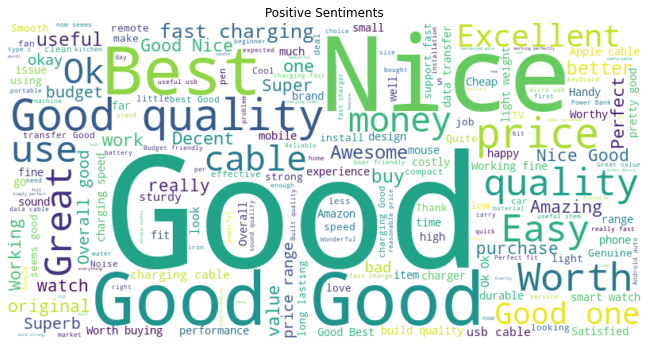

In [279]:
plt.figure(figsize=(25, 15))
plt.subplot(1, 2, 1)
plt.imshow(positive_wc, interpolation='bilinear')
plt.axis('off')
plt.title('Positive Sentiments')
plt.show()

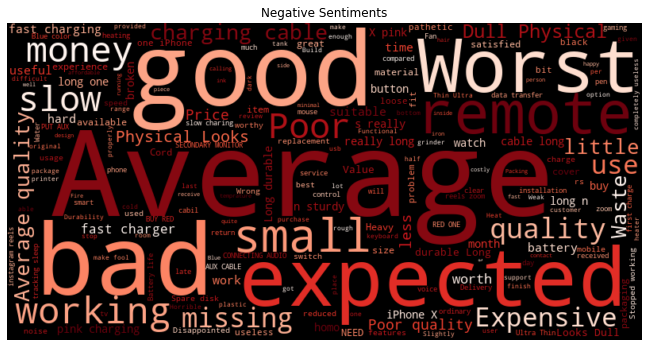

In [280]:
plt.figure(figsize=(25, 15))
plt.subplot(1, 2, 2)
plt.imshow(negative_wc, interpolation='bilinear')
plt.axis('off')
plt.title('Negative Sentiments')
plt.show()